In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def train_model(by_types):
    # load dataset
    timeSteps = 1
    dataset = by_types
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 2)

    
    # spiltting the data
    # training on only first year data
    features = by_types.shape[1]
    train_hours = int(0.7*len(values))
    X = np.asarray(reframed)[:,:(features*timeSteps)]
    y = np.asarray(reframed)[:,features*timeSteps]

    train_X = X[:train_hours,:]
    test_X = X[train_hours:,:]
    train_y = y[:train_hours]
    test_y = y[train_hours:]

    #convert data to fit for lstm
    #dimensions = (sample, timeSteps here it is 1, features )

    train_X = train_X.reshape(train_X.shape[0], timeSteps, features)
    test_X = test_X.reshape(test_X.shape[0], timeSteps, features)
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    #scale back the prediction to orginal scale
    y_pred = model.predict(test_X)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[2]*test_X.shape[1])

    inv_new = np.concatenate( (y_pred, test_X[:,:1] ) , axis =1)
    inv_new = scaler.inverse_transform(inv_new)
    final_pred = inv_new[:,0]

    test_y = test_y.reshape( len(test_y), 1)

    inv_new = np.concatenate( (test_y, test_X[:,:1] ) ,axis = 1)
    inv_new = scaler.inverse_transform(inv_new)
    actual_pred = inv_new[:,0]
    #plot the prediction with actual data
    
    aa=[x for x in range(200)]
    plt.figure(figsize = (20, 20))
    plt.plot(aa,final_pred[:200], marker = '.', label = "prediction",c = "b")
    plt.plot(aa,actual_pred[:200], marker = '.', label = "actual data",c="r")
    plt.title("comparison between prediction and actual data")
    plt.legend()
    #print(final_pred)
    #print(actual_pred)
    plt.show()
    
    
    """# make a prediction
    n_features = 2
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    #inv_yhat = concatenate((yhat, test_X[:, 2:]), axis=1)
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 2:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    aa=[x for x in range(100)]
    plt.figure(figsize = (20, 20))
    plt.plot(aa, inv_y[:100], marker='.', label="actual")
    plt.plot(aa, inv_yhat[:100], 'r', marker = '.', label="prediction")
    #print(inv_yhat[:100])
    plt.ylabel('Ask Price', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()"""

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Instructions for updating:
Use tf.cast instead.
Train on 17169 samples, validate on 7357 samples
Epoch 1/50
 - 1s - loss: 0.1290 - val_loss: 0.0992
Epoch 2/50
 - 1s - loss: 0.0679 - val_loss: 0.0813
Epoch 3/50
 - 1s - loss: 0.0403 - val_loss: 0.0411
Epoch 4/50
 - 1s - loss: 0.0261 - val_loss: 0.0219
Epoch 5/50
 - 1s - loss: 0.0167 - val_loss: 0.0166
Epoch 6/50
 - 1s - loss: 0.0132 - val_loss: 0.0085
Epoch 7/50
 - 1s - loss: 0.0112 - val_loss: 0.0070
Epoch 8/50
 - 1s - loss: 0.0104 - val_loss: 0.0059
Epoch 9/50
 - 1s - loss: 0.0091 - val_loss: 0.0040
Epoch 10/50
 - 1s - loss: 0.0073 - val_loss: 0.0038
Epoch 11/50
 - 1s - loss: 0.0060 - val_loss: 0.0039
Epoch 12/50
 - 1s - loss: 0.0059 - val_loss: 0.0051
Epoch 13/50
 - 1s - loss: 0.0052 - val_loss: 0.0054
Epoch 14/50
 - 1s - loss: 0.0047 - val_loss: 0.0070
Epoch 15/50
 - 1s - loss: 0.0045 - val_loss: 0.0070
Epoch 16/50
 - 1s - loss: 0.0043 - val_loss: 0.0042
Epoch 17/50
 - 1s - loss: 0.0043 - val_loss: 0.0047
Epoch 18/50
 - 1s - loss: 0.

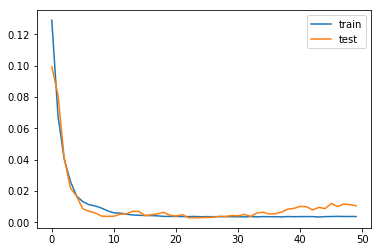

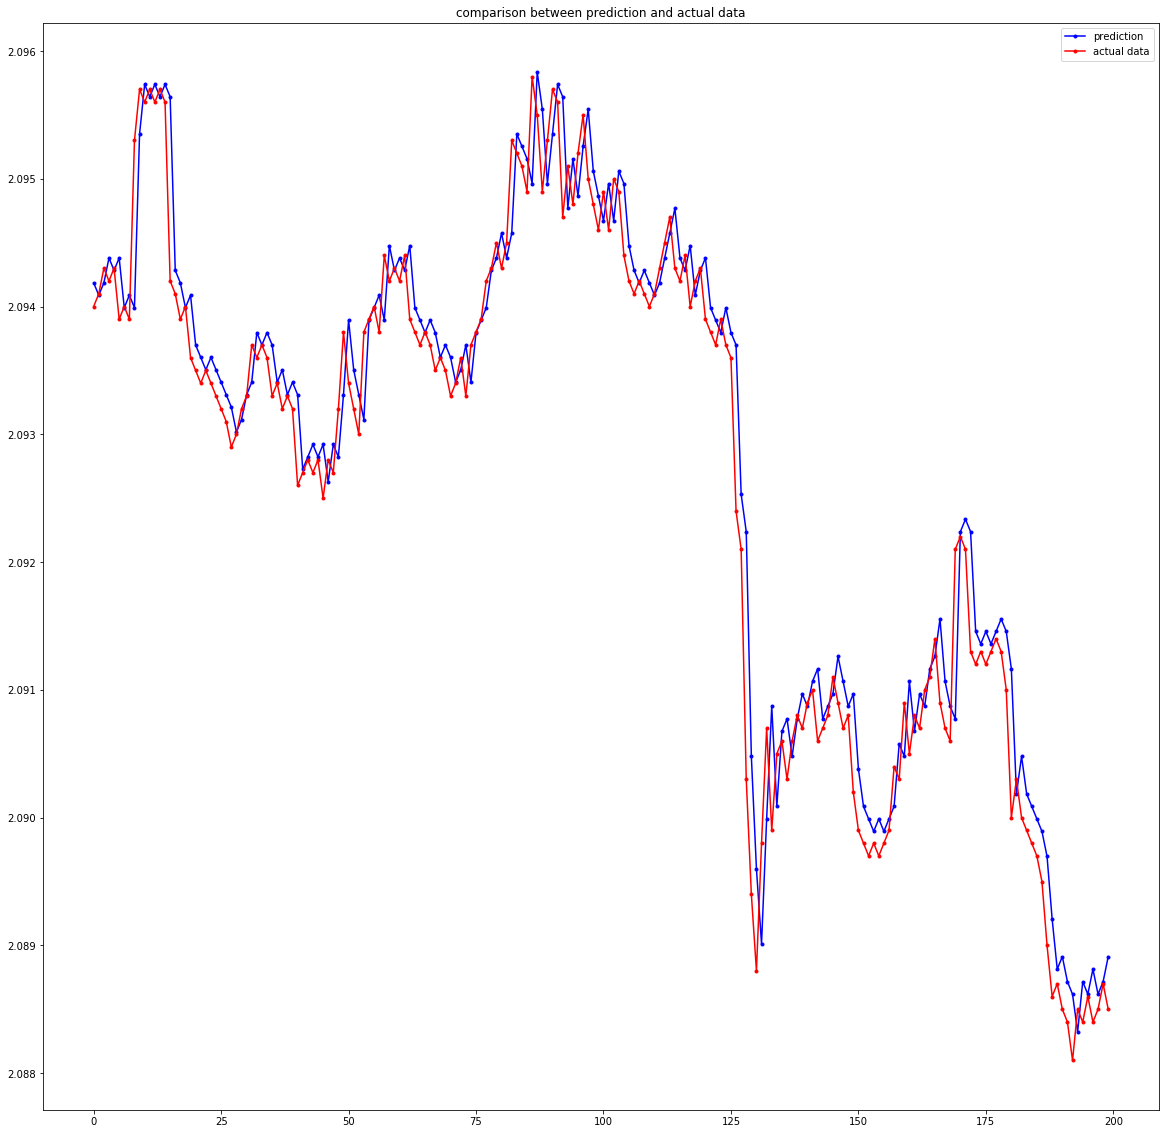

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 17206 samples, validate on 7373 samples
Epoch 1/50
 - 1s - loss: 0.1181 - val_loss: 0.0957
Epoch 2/50
 - 1s - loss: 0.0593 - val_loss: 0.0819
Epoch 3/50
 - 1s - loss: 0.0391 - val_loss: 0.0423
Epoch 4/50
 - 1s - loss: 0.0267 - val_loss: 0.0220
Epoch 5/50
 - 1s - loss: 0.0170 - val_loss: 0.0111
Epoch 6/50
 - 1s - loss: 0.0118 - val_loss: 0.0079
Epoch 7/50
 - 1s - loss: 0.0101 - val_loss: 0.0063
Epoch 8/50
 - 1s - loss: 0.0092 - val_loss: 0.0041
Epoch 9/50
 - 1s - loss: 0.0079 - val_loss: 0.0039
Epoch 10/50
 - 1s - loss: 0.0061 - val_loss: 0.0067
Epoch 11/50
 - 1s - loss: 0.0051 - val_loss: 0.0097
Epoch 12/50
 - 1s - loss: 0.0047 - val_loss: 0.0117
Epoch 13/50
 - 1s - loss: 0.0047 - val_loss: 0.0103
Epoch 14/50
 - 1s - loss: 0.0046 - val_loss: 0.0086
Epoch 15/50
 - 1s - loss: 0.0046 - val_loss: 0.0077
Epoch 16/50
 - 1s - loss: 0.0044 - val_loss: 0.0069
Epoch 17/50
 - 1s - loss: 0.0042 - val_loss: 0.0073
Epoch 18/50
 - 1s - loss: 0.0038 - val_loss: 0.0073
Epoch 19/50
 - 1s - loss

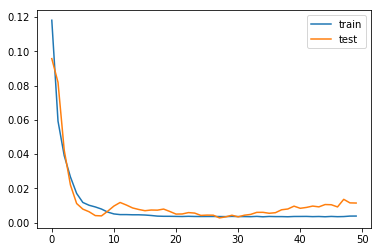

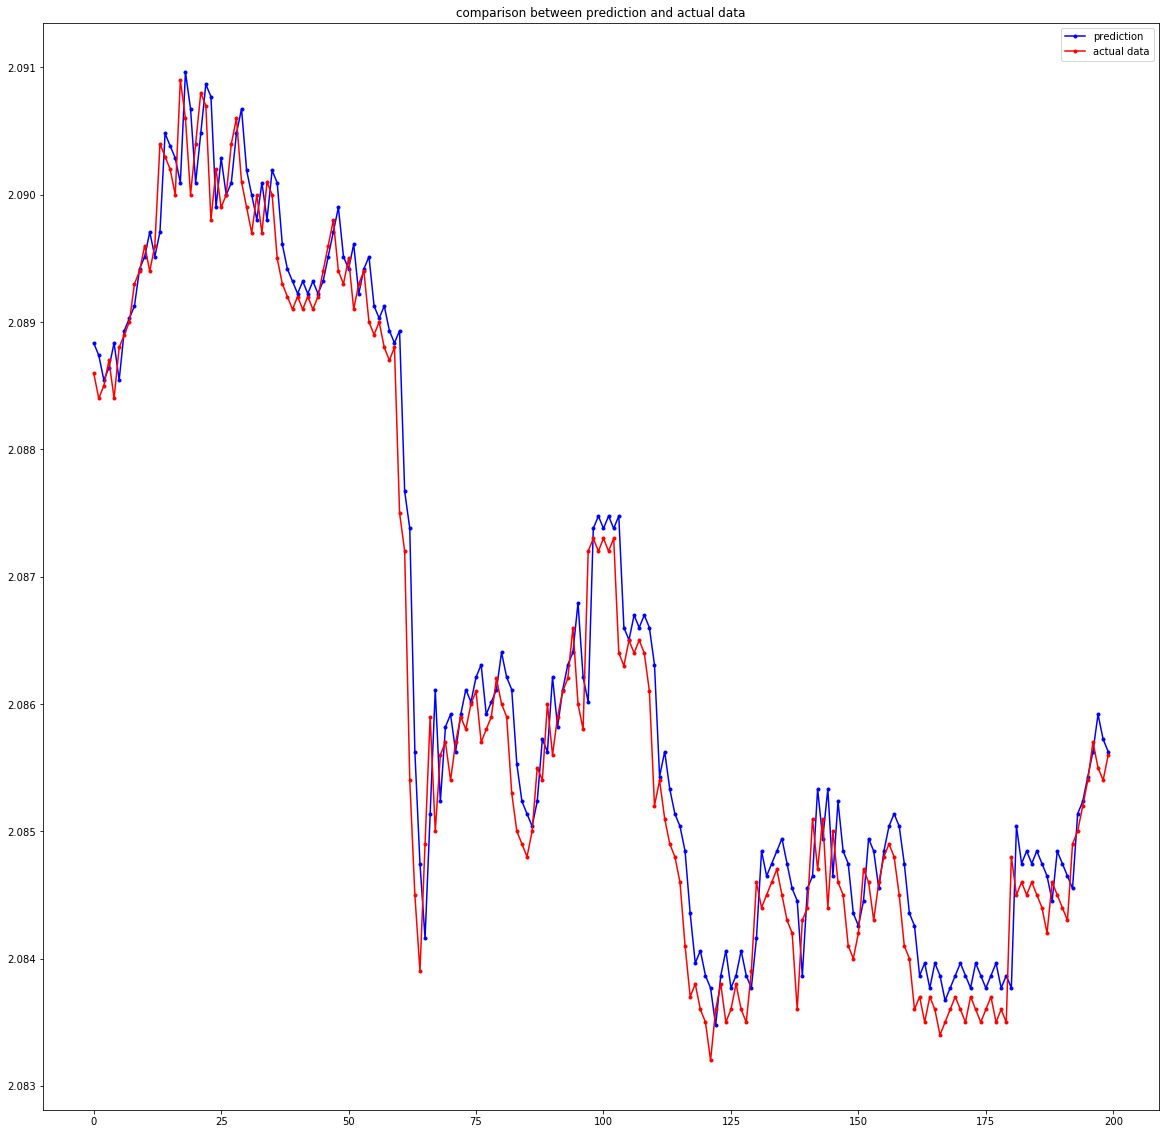

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 20336 samples, validate on 8714 samples
Epoch 1/50
 - 1s - loss: 0.0973 - val_loss: 0.1121
Epoch 2/50
 - 1s - loss: 0.0524 - val_loss: 0.0640
Epoch 3/50
 - 1s - loss: 0.0369 - val_loss: 0.0369
Epoch 4/50
 - 1s - loss: 0.0227 - val_loss: 0.0203
Epoch 5/50
 - 1s - loss: 0.0159 - val_loss: 0.0142
Epoch 6/50
 - 1s - loss: 0.0107 - val_loss: 0.0040
Epoch 7/50
 - 1s - loss: 0.0078 - val_loss: 0.0047
Epoch 8/50
 - 1s - loss: 0.0062 - val_loss: 0.0067
Epoch 9/50
 - 1s - loss: 0.0042 - val_loss: 0.0093
Epoch 10/50
 - 1s - loss: 0.0038 - val_loss: 0.0096
Epoch 11/50
 - 1s - loss: 0.0035 - val_loss: 0.0111
Epoch 12/50
 - 1s - loss: 0.0036 - val_loss: 0.0107
Epoch 13/50
 - 1s - loss: 0.0036 - val_loss: 0.0095
Epoch 14/50
 - 1s - loss: 0.0036 - val_loss: 0.0103
Epoch 15/50
 - 1s - loss: 0.0035 - val_loss: 0.0101
Epoch 16/50
 - 1s - loss: 0.0034 - val_loss: 0.0076
Epoch 17/50
 - 1s - loss: 0.0035 - val_loss: 0.0063
Epoch 18/50
 - 1s - loss: 0.0034 - val_loss: 0.0043
Epoch 19/50
 - 1s - loss

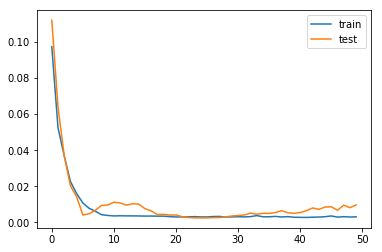

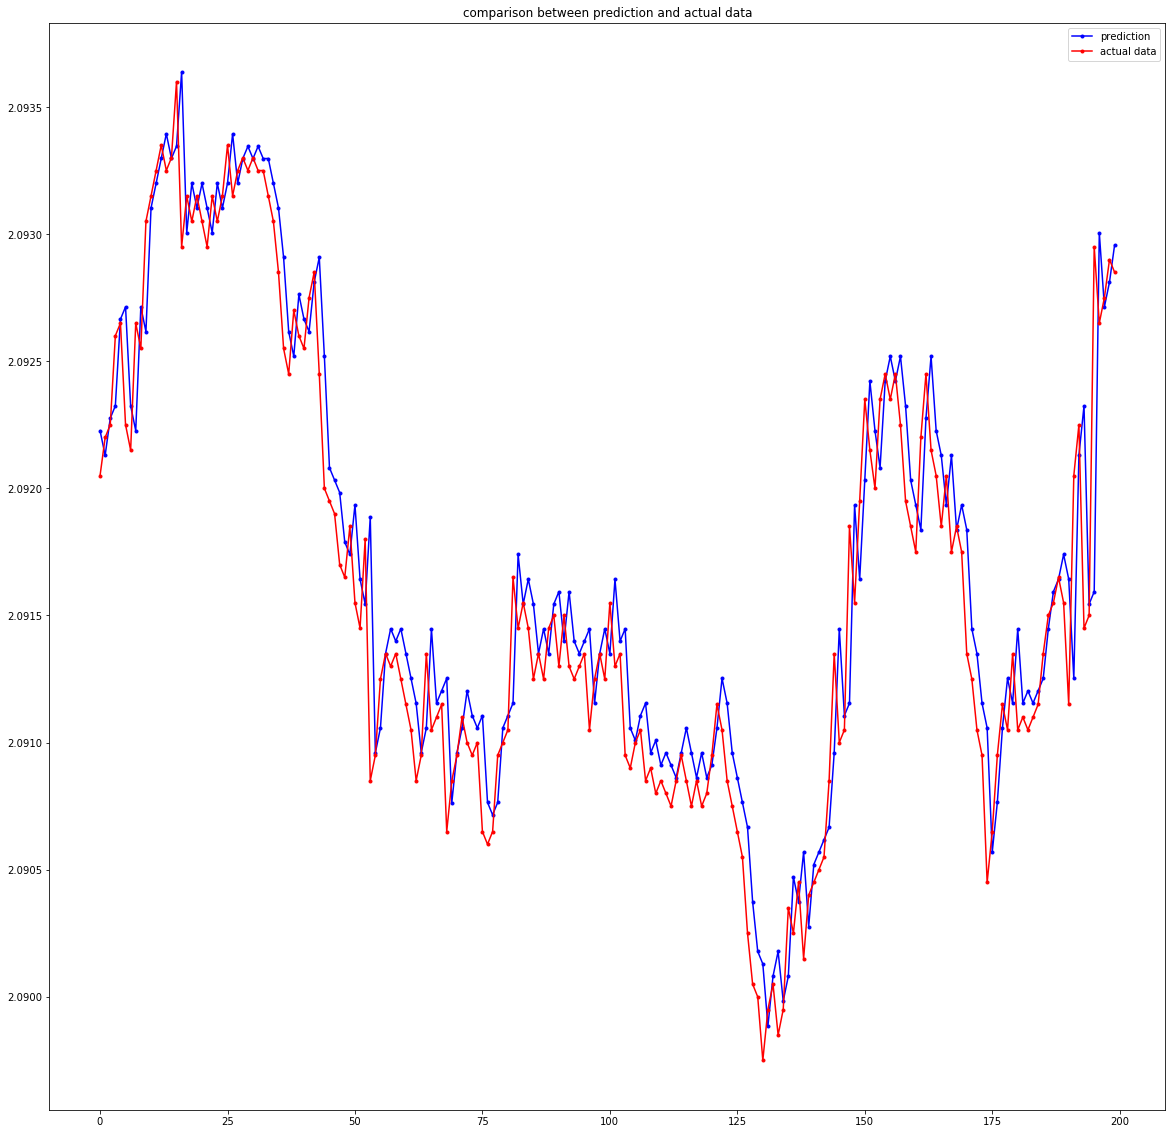

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 8066 samples, validate on 3456 samples
Epoch 1/50
 - 1s - loss: 0.1392 - val_loss: 0.0537
Epoch 2/50
 - 0s - loss: 0.1131 - val_loss: 0.0506
Epoch 3/50
 - 0s - loss: 0.0827 - val_loss: 0.0253
Epoch 4/50
 - 0s - loss: 0.0565 - val_loss: 0.0348
Epoch 5/50
 - 0s - loss: 0.0376 - val_loss: 0.0258
Epoch 6/50
 - 0s - loss: 0.0282 - val_loss: 0.0235
Epoch 7/50
 - 0s - loss: 0.0211 - val_loss: 0.0171
Epoch 8/50
 - 0s - loss: 0.0171 - val_loss: 0.0053
Epoch 9/50
 - 0s - loss: 0.0125 - val_loss: 0.0079
Epoch 10/50
 - 0s - loss: 0.0057 - val_loss: 0.0178
Epoch 11/50
 - 0s - loss: 0.0037 - val_loss: 0.0213
Epoch 12/50
 - 0s - loss: 0.0040 - val_loss: 0.0213
Epoch 13/50
 - 0s - loss: 0.0042 - val_loss: 0.0204
Epoch 14/50
 - 0s - loss: 0.0038 - val_loss: 0.0205
Epoch 15/50
 - 0s - loss: 0.0040 - val_loss: 0.0219
Epoch 16/50
 - 0s - loss: 0.0042 - val_loss: 0.0206
Epoch 17/50
 - 0s - loss: 0.0041 - val_loss: 0.0213
Epoch 18/50
 - 0s - loss: 0.0041 - val_loss: 0.0201
Epoch 19/50
 - 0s - loss:

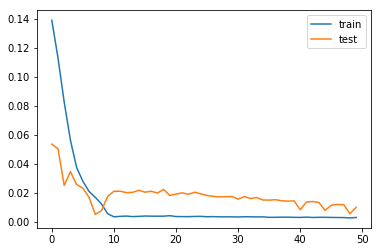

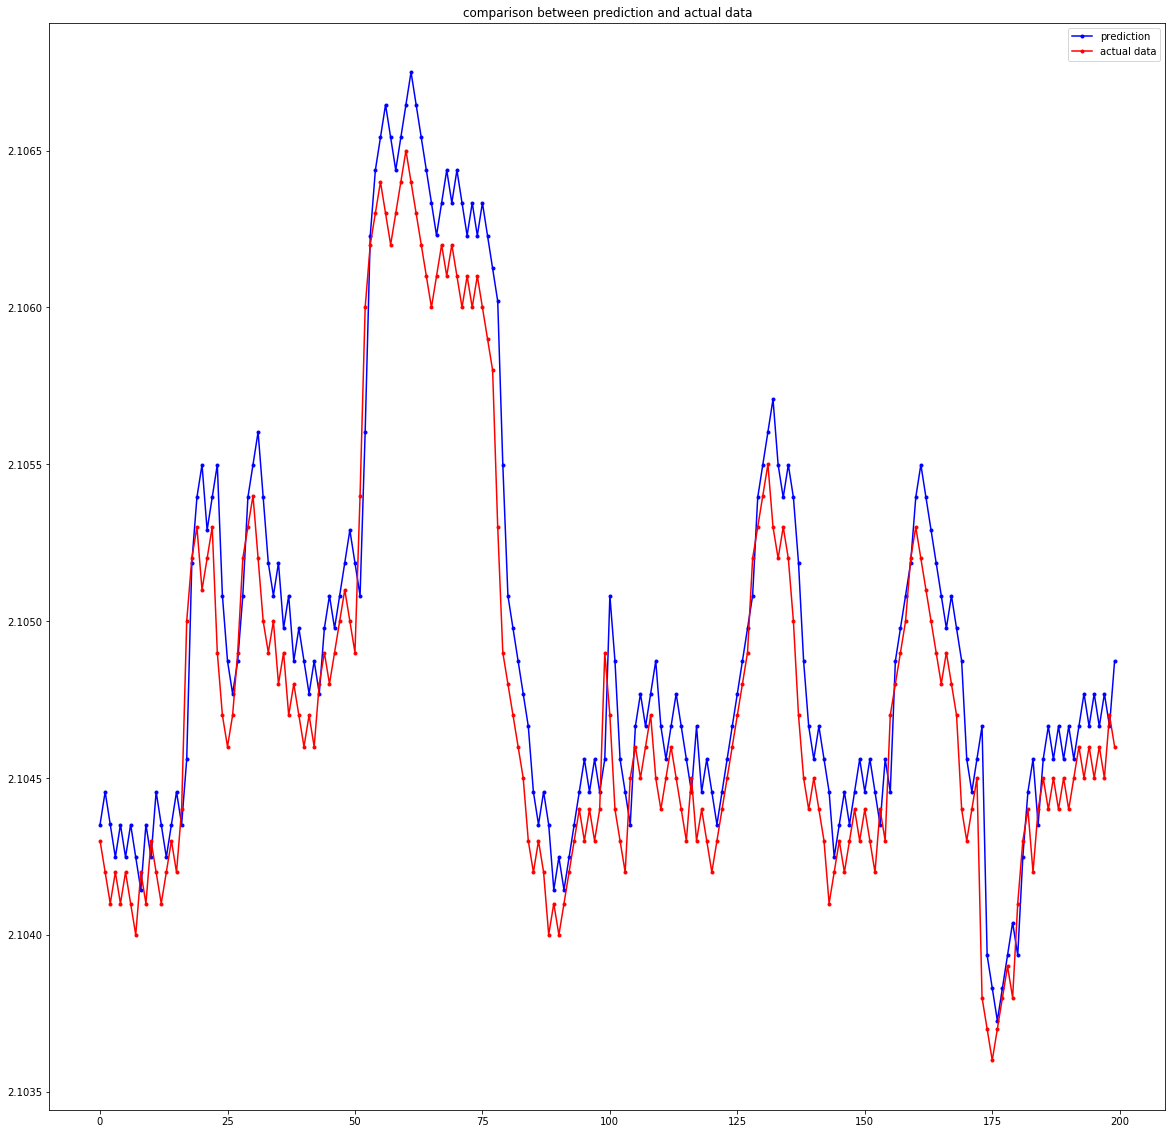

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 8066 samples, validate on 3456 samples
Epoch 1/50
 - 1s - loss: 0.1515 - val_loss: 0.0685
Epoch 2/50
 - 0s - loss: 0.1200 - val_loss: 0.0774
Epoch 3/50
 - 0s - loss: 0.1089 - val_loss: 0.0336
Epoch 4/50
 - 0s - loss: 0.0830 - val_loss: 0.0507
Epoch 5/50
 - 0s - loss: 0.0331 - val_loss: 0.0283
Epoch 6/50
 - 0s - loss: 0.0302 - val_loss: 0.0264
Epoch 7/50
 - 0s - loss: 0.0232 - val_loss: 0.0209
Epoch 8/50
 - 0s - loss: 0.0194 - val_loss: 0.0126
Epoch 9/50
 - 0s - loss: 0.0150 - val_loss: 0.0022
Epoch 10/50
 - 0s - loss: 0.0109 - val_loss: 0.0128
Epoch 11/50
 - 0s - loss: 0.0046 - val_loss: 0.0170
Epoch 12/50
 - 0s - loss: 0.0035 - val_loss: 0.0189
Epoch 13/50
 - 0s - loss: 0.0038 - val_loss: 0.0218
Epoch 14/50
 - 0s - loss: 0.0040 - val_loss: 0.0210
Epoch 15/50
 - 0s - loss: 0.0041 - val_loss: 0.0222
Epoch 16/50
 - 0s - loss: 0.0044 - val_loss: 0.0197
Epoch 17/50
 - 0s - loss: 0.0039 - val_loss: 0.0212
Epoch 18/50
 - 0s - loss: 0.0039 - val_loss: 0.0204
Epoch 19/50
 - 0s - loss:

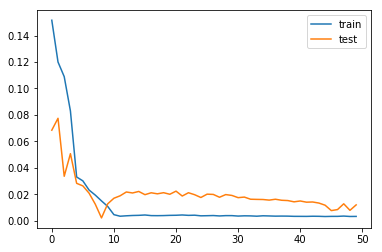

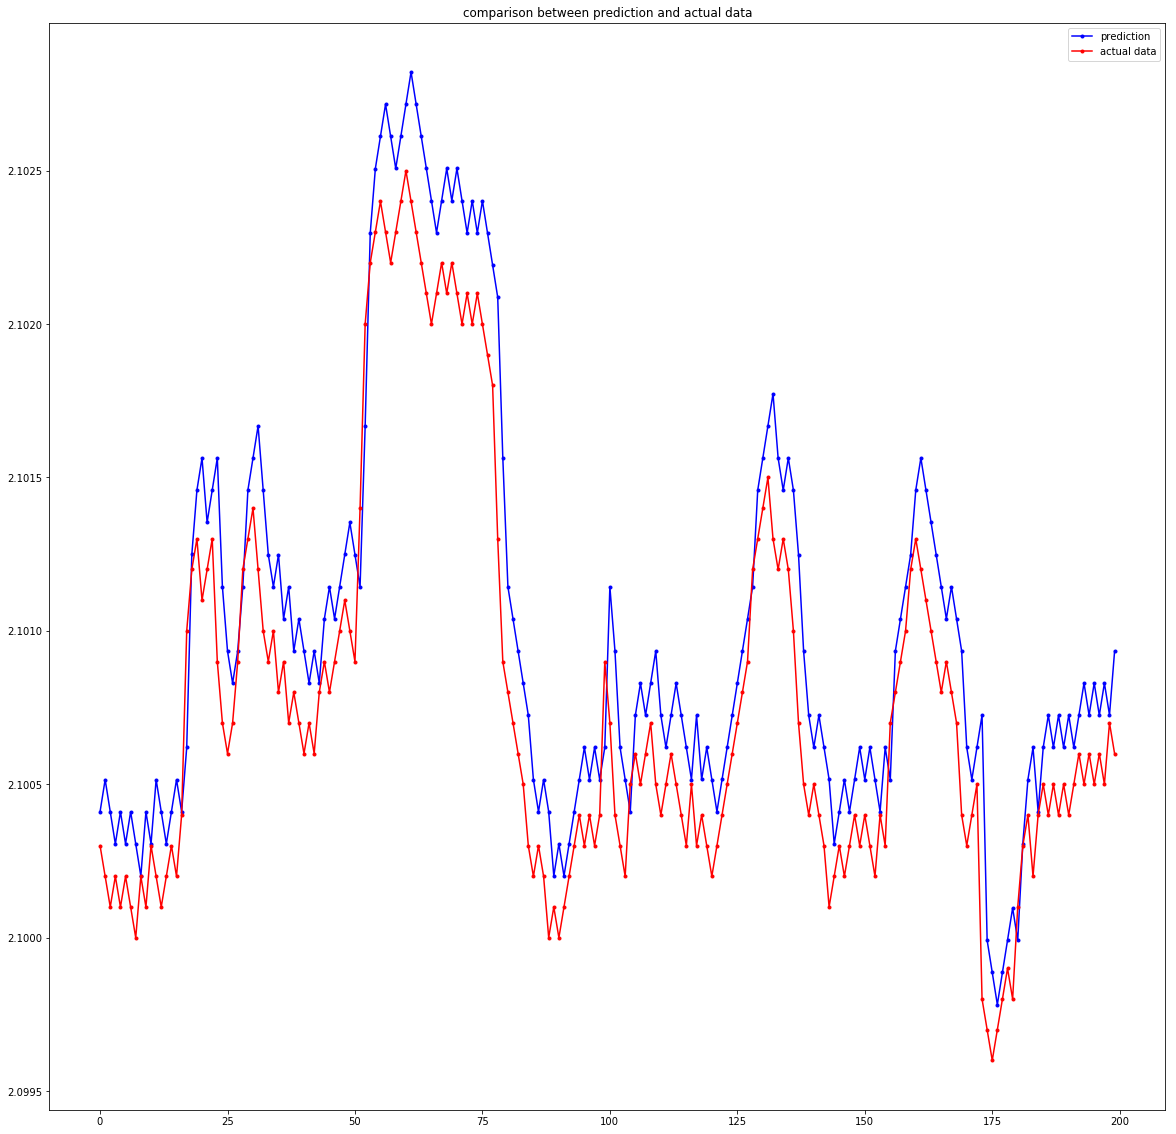

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 8066 samples, validate on 3456 samples
Epoch 1/50
 - 1s - loss: 0.1791 - val_loss: 0.1674
Epoch 2/50
 - 0s - loss: 0.1302 - val_loss: 0.0494
Epoch 3/50
 - 0s - loss: 0.1142 - val_loss: 0.0367
Epoch 4/50
 - 0s - loss: 0.0965 - val_loss: 0.0241
Epoch 5/50
 - 0s - loss: 0.0628 - val_loss: 0.0482
Epoch 6/50
 - 0s - loss: 0.0349 - val_loss: 0.0278
Epoch 7/50
 - 0s - loss: 0.0320 - val_loss: 0.0200
Epoch 8/50
 - 0s - loss: 0.0255 - val_loss: 0.0166
Epoch 9/50
 - 0s - loss: 0.0185 - val_loss: 0.0052
Epoch 10/50
 - 0s - loss: 0.0140 - val_loss: 0.0065
Epoch 11/50
 - 0s - loss: 0.0097 - val_loss: 0.0170
Epoch 12/50
 - 0s - loss: 0.0039 - val_loss: 0.0235
Epoch 13/50
 - 0s - loss: 0.0040 - val_loss: 0.0230
Epoch 14/50
 - 0s - loss: 0.0045 - val_loss: 0.0251
Epoch 15/50
 - 0s - loss: 0.0057 - val_loss: 0.0240
Epoch 16/50
 - 0s - loss: 0.0062 - val_loss: 0.0219
Epoch 17/50
 - 0s - loss: 0.0052 - val_loss: 0.0248
Epoch 18/50
 - 0s - loss: 0.0060 - val_loss: 0.0234
Epoch 19/50
 - 0s - loss:

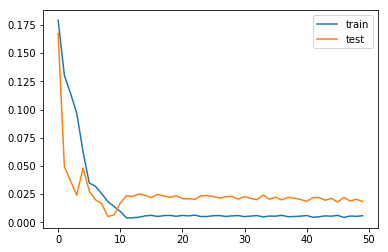

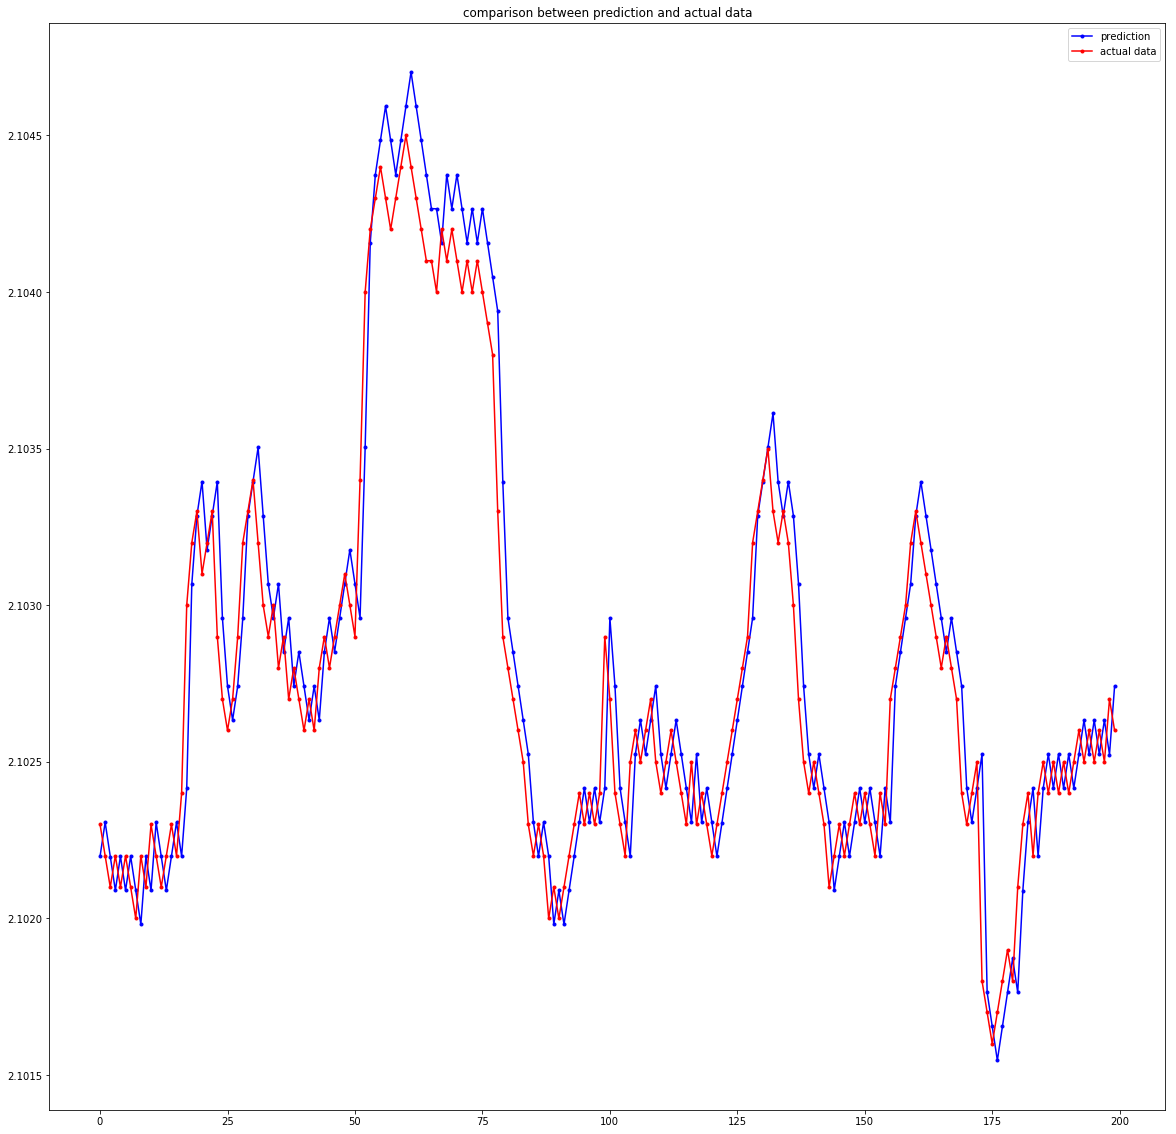

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 7932 samples, validate on 3398 samples
Epoch 1/50
 - 1s - loss: 0.1360 - val_loss: 0.2449
Epoch 2/50
 - 0s - loss: 0.0736 - val_loss: 0.1976
Epoch 3/50
 - 0s - loss: 0.0614 - val_loss: 0.1367
Epoch 4/50
 - 0s - loss: 0.0493 - val_loss: 0.0721
Epoch 5/50
 - 0s - loss: 0.0362 - val_loss: 0.0220
Epoch 6/50
 - 0s - loss: 0.0256 - val_loss: 0.0090
Epoch 7/50
 - 0s - loss: 0.0124 - val_loss: 0.0107
Epoch 8/50
 - 0s - loss: 0.0088 - val_loss: 0.0128
Epoch 9/50
 - 0s - loss: 0.0087 - val_loss: 0.0117
Epoch 10/50
 - 0s - loss: 0.0087 - val_loss: 0.0110
Epoch 11/50
 - 0s - loss: 0.0088 - val_loss: 0.0100
Epoch 12/50
 - 0s - loss: 0.0087 - val_loss: 0.0108
Epoch 13/50
 - 0s - loss: 0.0088 - val_loss: 0.0097
Epoch 14/50
 - 0s - loss: 0.0089 - val_loss: 0.0098
Epoch 15/50
 - 0s - loss: 0.0088 - val_loss: 0.0089
Epoch 16/50
 - 0s - loss: 0.0088 - val_loss: 0.0091
Epoch 17/50
 - 0s - loss: 0.0089 - val_loss: 0.0093
Epoch 18/50
 - 0s - loss: 0.0088 - val_loss: 0.0082
Epoch 19/50
 - 0s - loss:

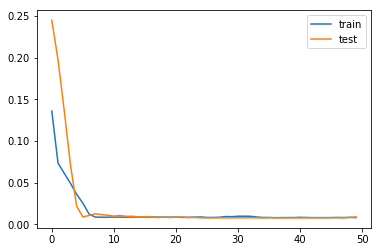

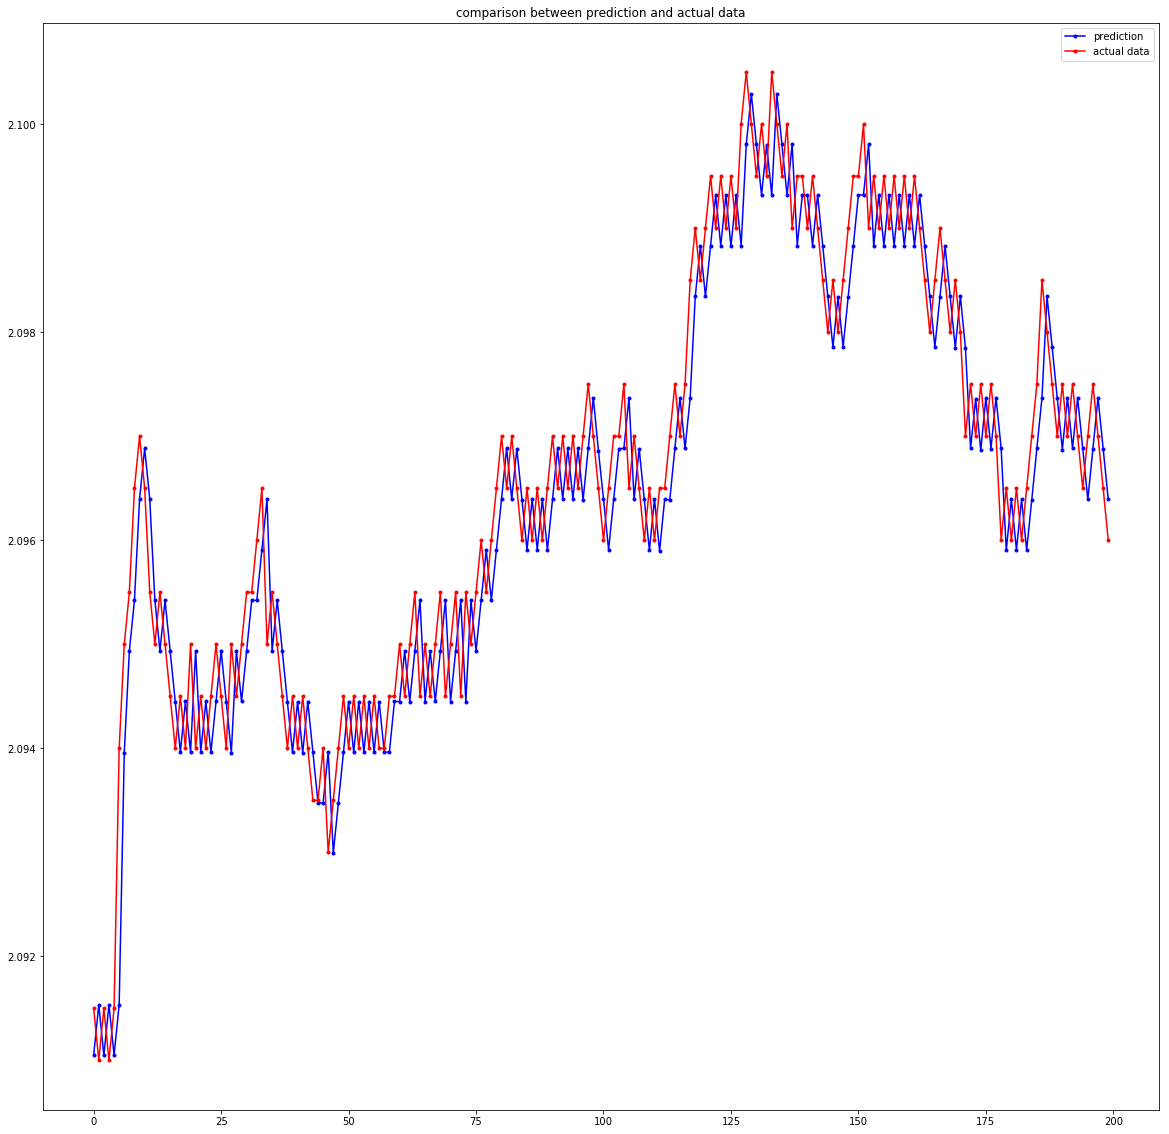

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 7933 samples, validate on 3399 samples
Epoch 1/50
 - 2s - loss: 0.1403 - val_loss: 0.2457
Epoch 2/50
 - 0s - loss: 0.0742 - val_loss: 0.2070
Epoch 3/50
 - 0s - loss: 0.0633 - val_loss: 0.1556
Epoch 4/50
 - 0s - loss: 0.0525 - val_loss: 0.0995
Epoch 5/50
 - 0s - loss: 0.0417 - val_loss: 0.0458
Epoch 6/50
 - 0s - loss: 0.0316 - val_loss: 0.0135
Epoch 7/50
 - 0s - loss: 0.0222 - val_loss: 0.0102
Epoch 8/50
 - 0s - loss: 0.0126 - val_loss: 0.0111
Epoch 9/50
 - 0s - loss: 0.0089 - val_loss: 0.0145
Epoch 10/50
 - 0s - loss: 0.0086 - val_loss: 0.0159
Epoch 11/50
 - 0s - loss: 0.0087 - val_loss: 0.0130
Epoch 12/50
 - 0s - loss: 0.0087 - val_loss: 0.0124
Epoch 13/50
 - 0s - loss: 0.0086 - val_loss: 0.0123
Epoch 14/50
 - 0s - loss: 0.0086 - val_loss: 0.0118
Epoch 15/50
 - 0s - loss: 0.0089 - val_loss: 0.0100
Epoch 16/50
 - 0s - loss: 0.0087 - val_loss: 0.0116
Epoch 17/50
 - 0s - loss: 0.0089 - val_loss: 0.0091
Epoch 18/50
 - 0s - loss: 0.0088 - val_loss: 0.0110
Epoch 19/50
 - 0s - loss:

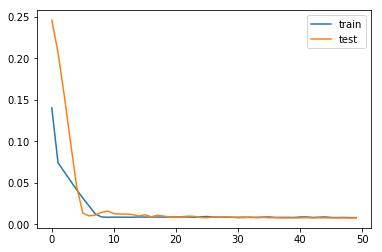

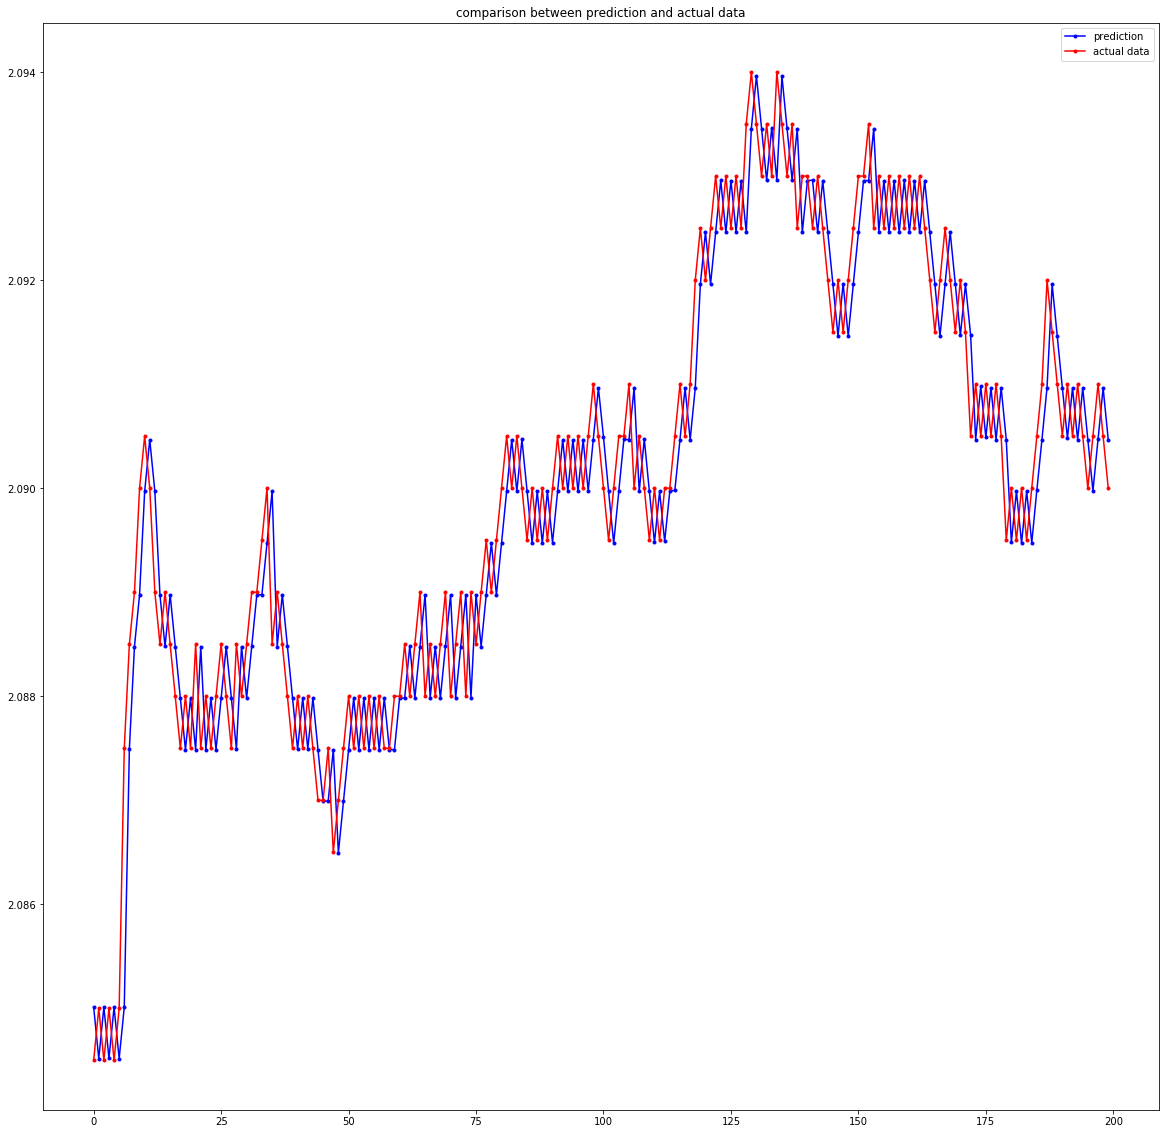

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 7934 samples, validate on 3399 samples
Epoch 1/50
 - 2s - loss: 0.1389 - val_loss: 0.2532
Epoch 2/50
 - 0s - loss: 0.0742 - val_loss: 0.2088
Epoch 3/50
 - 0s - loss: 0.0626 - val_loss: 0.1518
Epoch 4/50
 - 0s - loss: 0.0505 - val_loss: 0.0862
Epoch 5/50
 - 0s - loss: 0.0378 - val_loss: 0.0281
Epoch 6/50
 - 0s - loss: 0.0275 - val_loss: 0.0087
Epoch 7/50
 - 0s - loss: 0.0147 - val_loss: 0.0113
Epoch 8/50
 - 0s - loss: 0.0087 - val_loss: 0.0159
Epoch 9/50
 - 0s - loss: 0.0087 - val_loss: 0.0138
Epoch 10/50
 - 0s - loss: 0.0087 - val_loss: 0.0113
Epoch 11/50
 - 0s - loss: 0.0088 - val_loss: 0.0094
Epoch 12/50
 - 0s - loss: 0.0090 - val_loss: 0.0084
Epoch 13/50
 - 0s - loss: 0.0089 - val_loss: 0.0100
Epoch 14/50
 - 0s - loss: 0.0090 - val_loss: 0.0085
Epoch 15/50
 - 0s - loss: 0.0091 - val_loss: 0.0083
Epoch 16/50
 - 0s - loss: 0.0090 - val_loss: 0.0095
Epoch 17/50
 - 0s - loss: 0.0088 - val_loss: 0.0081
Epoch 18/50
 - 0s - loss: 0.0089 - val_loss: 0.0082
Epoch 19/50
 - 0s - loss:

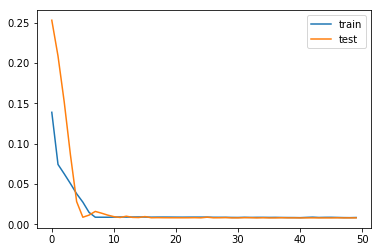

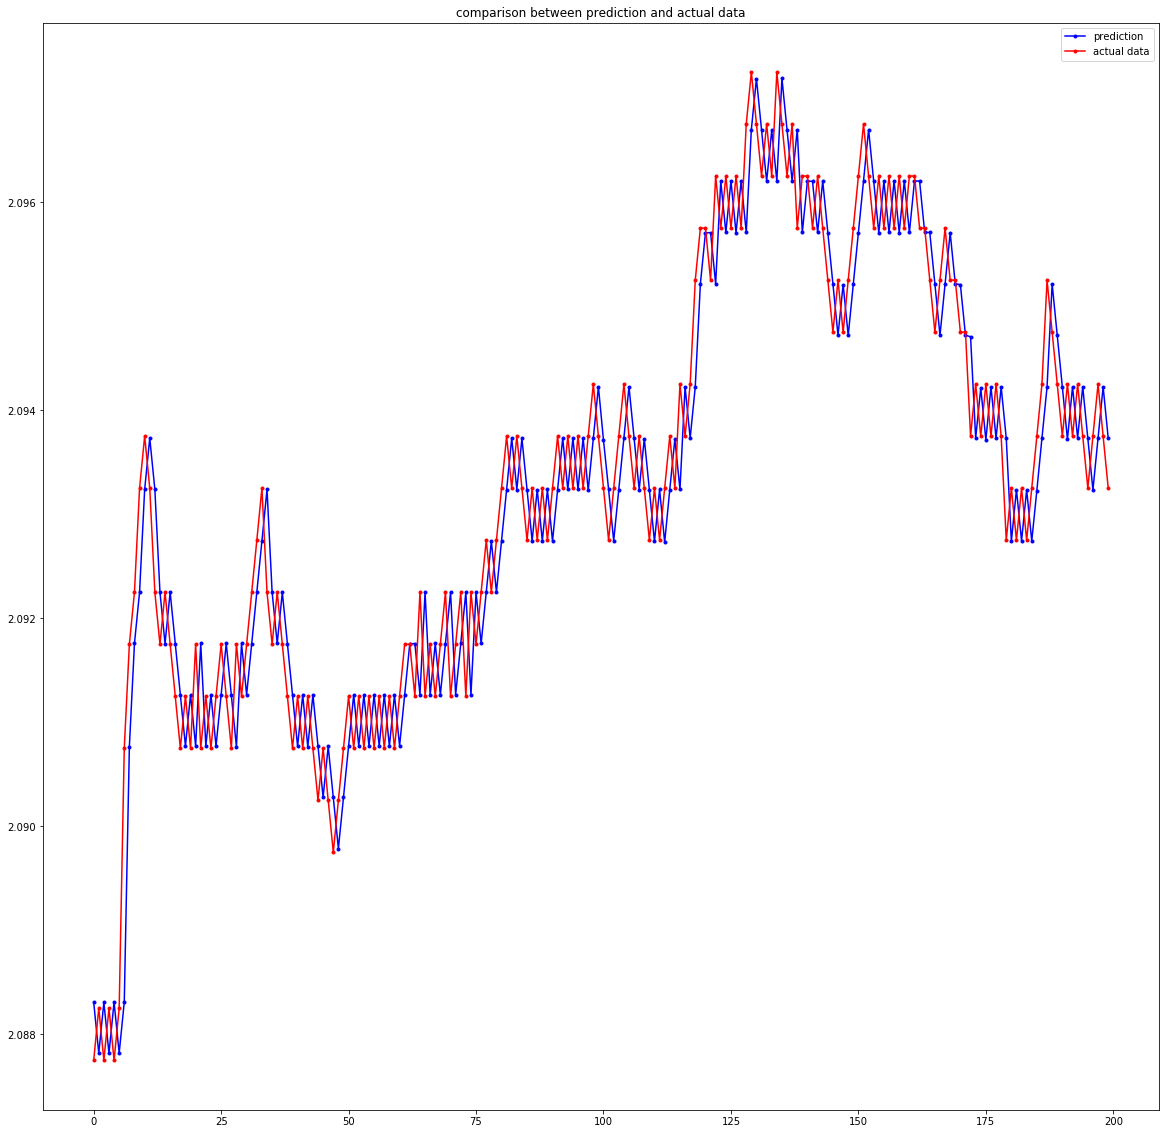

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 18197 samples, validate on 7797 samples
Epoch 1/50
 - 2s - loss: 0.1066 - val_loss: 0.0957
Epoch 2/50
 - 1s - loss: 0.0609 - val_loss: 0.0602
Epoch 3/50
 - 1s - loss: 0.0393 - val_loss: 0.0373
Epoch 4/50
 - 1s - loss: 0.0293 - val_loss: 0.0212
Epoch 5/50
 - 1s - loss: 0.0151 - val_loss: 0.0143
Epoch 6/50
 - 1s - loss: 0.0102 - val_loss: 0.0067
Epoch 7/50
 - 1s - loss: 0.0076 - val_loss: 0.0080
Epoch 8/50
 - 1s - loss: 0.0063 - val_loss: 0.0129
Epoch 9/50
 - 1s - loss: 0.0059 - val_loss: 0.0138
Epoch 10/50
 - 1s - loss: 0.0058 - val_loss: 0.0158
Epoch 11/50
 - 1s - loss: 0.0058 - val_loss: 0.0151
Epoch 12/50
 - 1s - loss: 0.0057 - val_loss: 0.0121
Epoch 13/50
 - 1s - loss: 0.0056 - val_loss: 0.0108
Epoch 14/50
 - 1s - loss: 0.0056 - val_loss: 0.0097
Epoch 15/50
 - 1s - loss: 0.0055 - val_loss: 0.0093
Epoch 16/50
 - 1s - loss: 0.0055 - val_loss: 0.0079
Epoch 17/50
 - 1s - loss: 0.0055 - val_loss: 0.0076
Epoch 18/50
 - 1s - loss: 0.0056 - val_loss: 0.0069
Epoch 19/50
 - 1s - loss

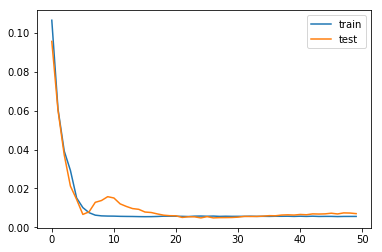

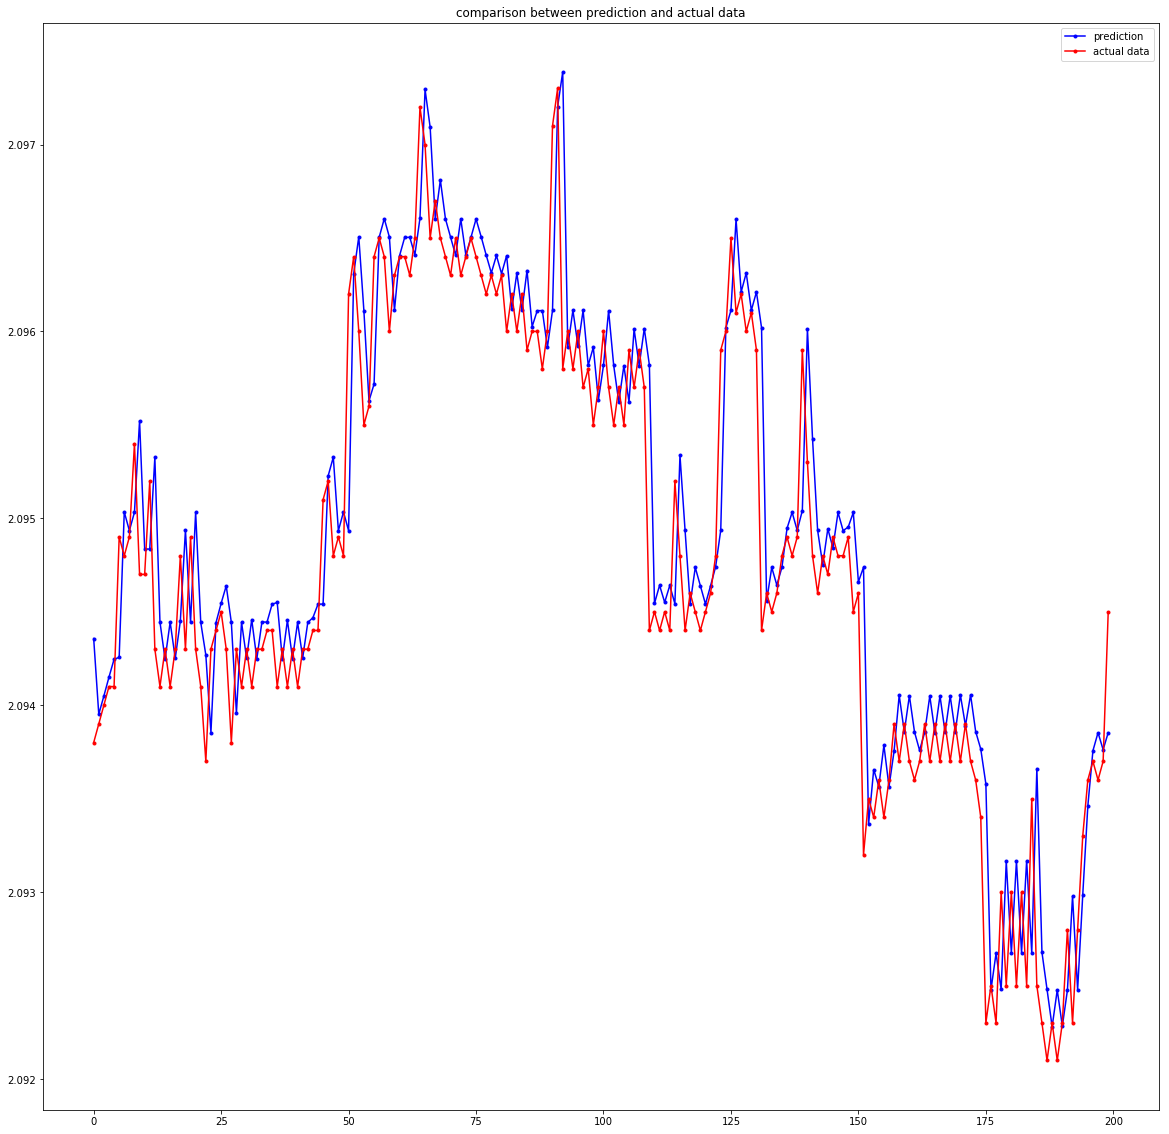

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 18197 samples, validate on 7797 samples
Epoch 1/50
 - 2s - loss: 0.1054 - val_loss: 0.0891
Epoch 2/50
 - 1s - loss: 0.0588 - val_loss: 0.0569
Epoch 3/50
 - 1s - loss: 0.0388 - val_loss: 0.0346
Epoch 4/50
 - 1s - loss: 0.0288 - val_loss: 0.0201
Epoch 5/50
 - 1s - loss: 0.0148 - val_loss: 0.0136
Epoch 6/50
 - 1s - loss: 0.0098 - val_loss: 0.0055
Epoch 7/50
 - 1s - loss: 0.0072 - val_loss: 0.0099
Epoch 8/50
 - 1s - loss: 0.0062 - val_loss: 0.0136
Epoch 9/50
 - 1s - loss: 0.0059 - val_loss: 0.0149
Epoch 10/50
 - 1s - loss: 0.0059 - val_loss: 0.0151
Epoch 11/50
 - 1s - loss: 0.0059 - val_loss: 0.0133
Epoch 12/50
 - 1s - loss: 0.0057 - val_loss: 0.0143
Epoch 13/50
 - 1s - loss: 0.0056 - val_loss: 0.0113
Epoch 14/50
 - 1s - loss: 0.0057 - val_loss: 0.0102
Epoch 15/50
 - 1s - loss: 0.0056 - val_loss: 0.0100
Epoch 16/50
 - 1s - loss: 0.0055 - val_loss: 0.0092
Epoch 17/50
 - 1s - loss: 0.0055 - val_loss: 0.0083
Epoch 18/50
 - 1s - loss: 0.0055 - val_loss: 0.0077
Epoch 19/50
 - 1s - loss

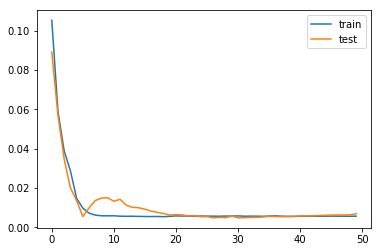

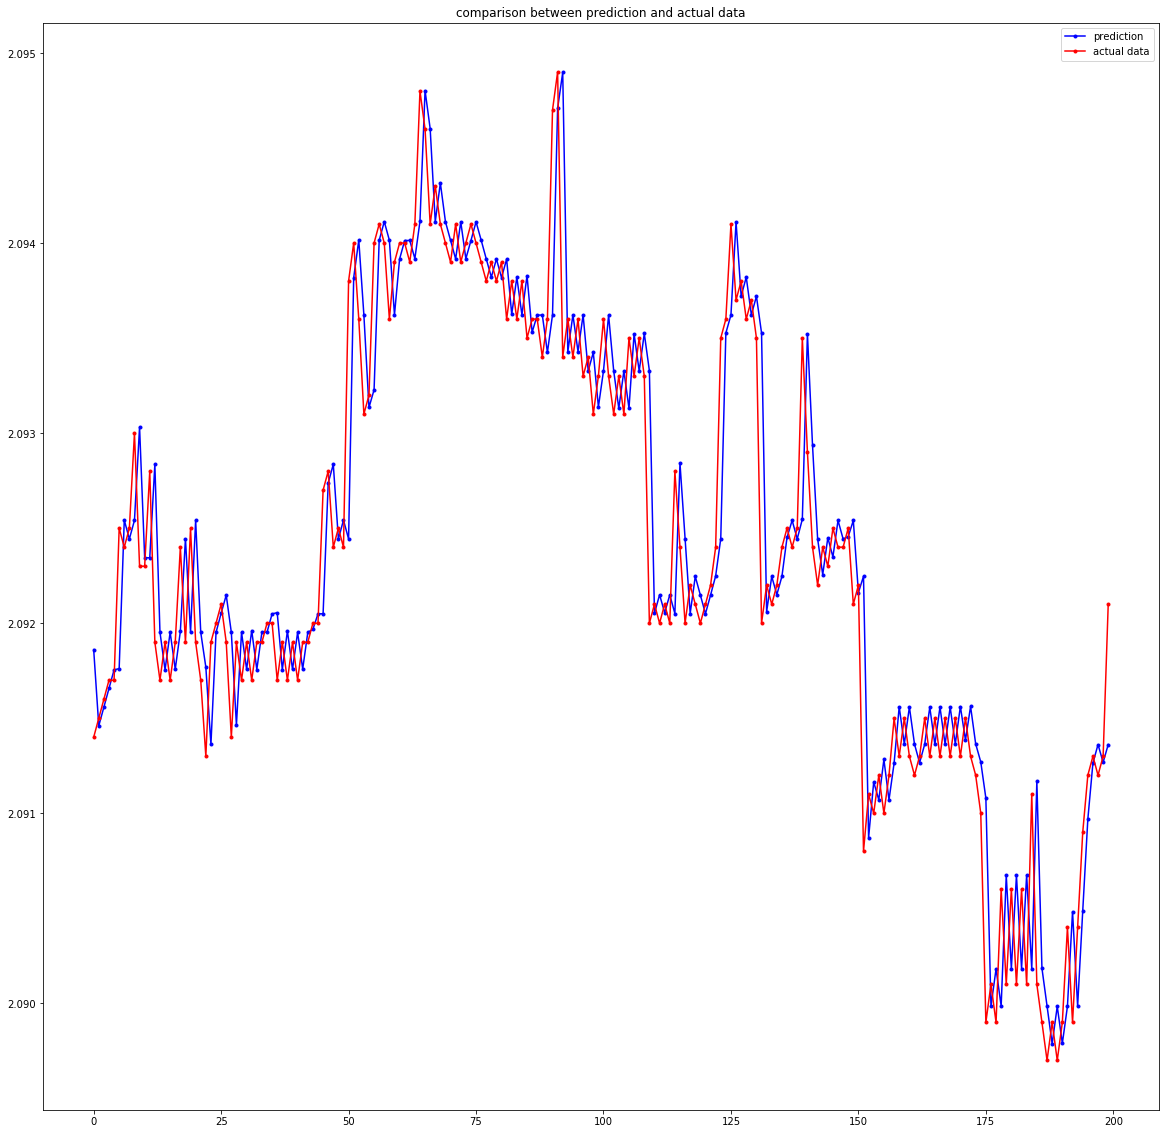

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 18197 samples, validate on 7797 samples
Epoch 1/50
 - 2s - loss: 0.0945 - val_loss: 0.0772
Epoch 2/50
 - 1s - loss: 0.0523 - val_loss: 0.0529
Epoch 3/50
 - 1s - loss: 0.0338 - val_loss: 0.0294
Epoch 4/50
 - 1s - loss: 0.0212 - val_loss: 0.0220
Epoch 5/50
 - 1s - loss: 0.0129 - val_loss: 0.0135
Epoch 6/50
 - 1s - loss: 0.0088 - val_loss: 0.0054
Epoch 7/50
 - 1s - loss: 0.0066 - val_loss: 0.0089
Epoch 8/50
 - 1s - loss: 0.0059 - val_loss: 0.0116
Epoch 9/50
 - 1s - loss: 0.0057 - val_loss: 0.0127
Epoch 10/50
 - 1s - loss: 0.0057 - val_loss: 0.0131
Epoch 11/50
 - 1s - loss: 0.0056 - val_loss: 0.0106
Epoch 12/50
 - 1s - loss: 0.0056 - val_loss: 0.0087
Epoch 13/50
 - 1s - loss: 0.0056 - val_loss: 0.0076
Epoch 14/50
 - 1s - loss: 0.0056 - val_loss: 0.0070
Epoch 15/50
 - 1s - loss: 0.0056 - val_loss: 0.0065
Epoch 16/50
 - 1s - loss: 0.0057 - val_loss: 0.0071
Epoch 17/50
 - 1s - loss: 0.0059 - val_loss: 0.0065
Epoch 18/50
 - 1s - loss: 0.0058 - val_loss: 0.0062
Epoch 19/50
 - 1s - loss

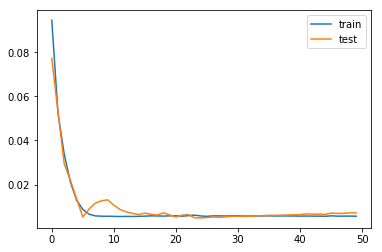

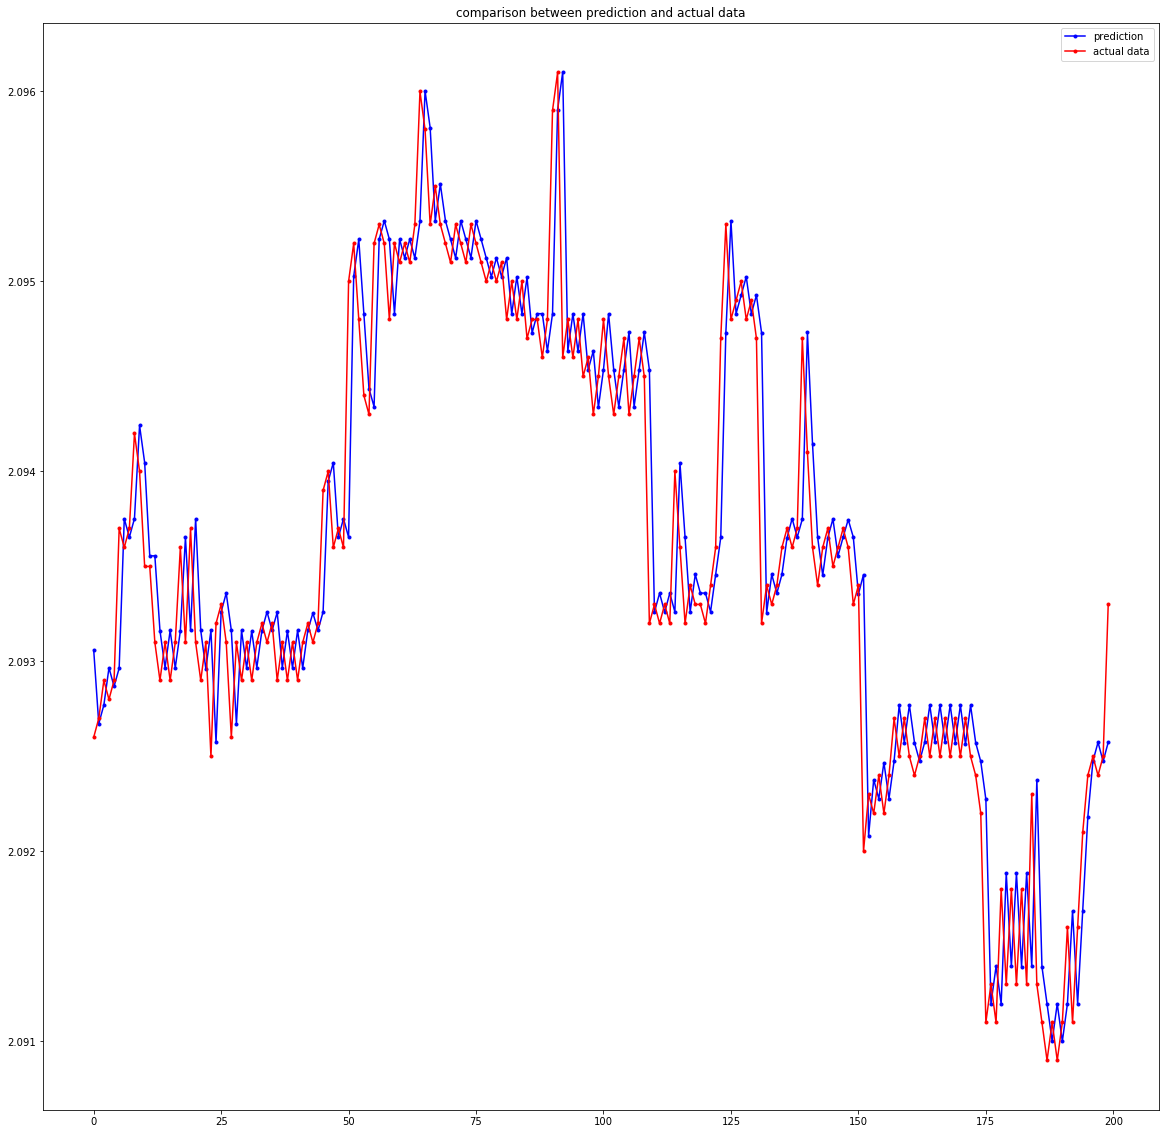

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 13342 samples, validate on 5717 samples
Epoch 1/50
 - 2s - loss: 0.0067 - val_loss: 0.0091
Epoch 2/50
 - 0s - loss: 0.0063 - val_loss: 0.0095
Epoch 3/50
 - 0s - loss: 0.0065 - val_loss: 0.0114
Epoch 4/50
 - 0s - loss: 0.0058 - val_loss: 0.0120
Epoch 5/50
 - 0s - loss: 0.0058 - val_loss: 0.0132
Epoch 6/50
 - 0s - loss: 0.0059 - val_loss: 0.0133
Epoch 7/50
 - 0s - loss: 0.0058 - val_loss: 0.0135
Epoch 8/50
 - 0s - loss: 0.0059 - val_loss: 0.0136
Epoch 9/50
 - 0s - loss: 0.0058 - val_loss: 0.0136
Epoch 10/50
 - 0s - loss: 0.0059 - val_loss: 0.0137
Epoch 11/50
 - 0s - loss: 0.0059 - val_loss: 0.0137
Epoch 12/50
 - 0s - loss: 0.0059 - val_loss: 0.0137
Epoch 13/50
 - 0s - loss: 0.0059 - val_loss: 0.0138
Epoch 14/50
 - 0s - loss: 0.0060 - val_loss: 0.0137
Epoch 15/50
 - 0s - loss: 0.0059 - val_loss: 0.0139
Epoch 16/50
 - 0s - loss: 0.0060 - val_loss: 0.0137
Epoch 17/50
 - 0s - loss: 0.0059 - val_loss: 0.0138
Epoch 18/50
 - 1s - loss: 0.0059 - val_loss: 0.0138
Epoch 19/50
 - 1s - loss

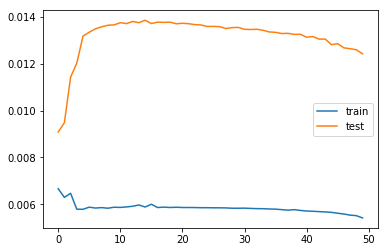

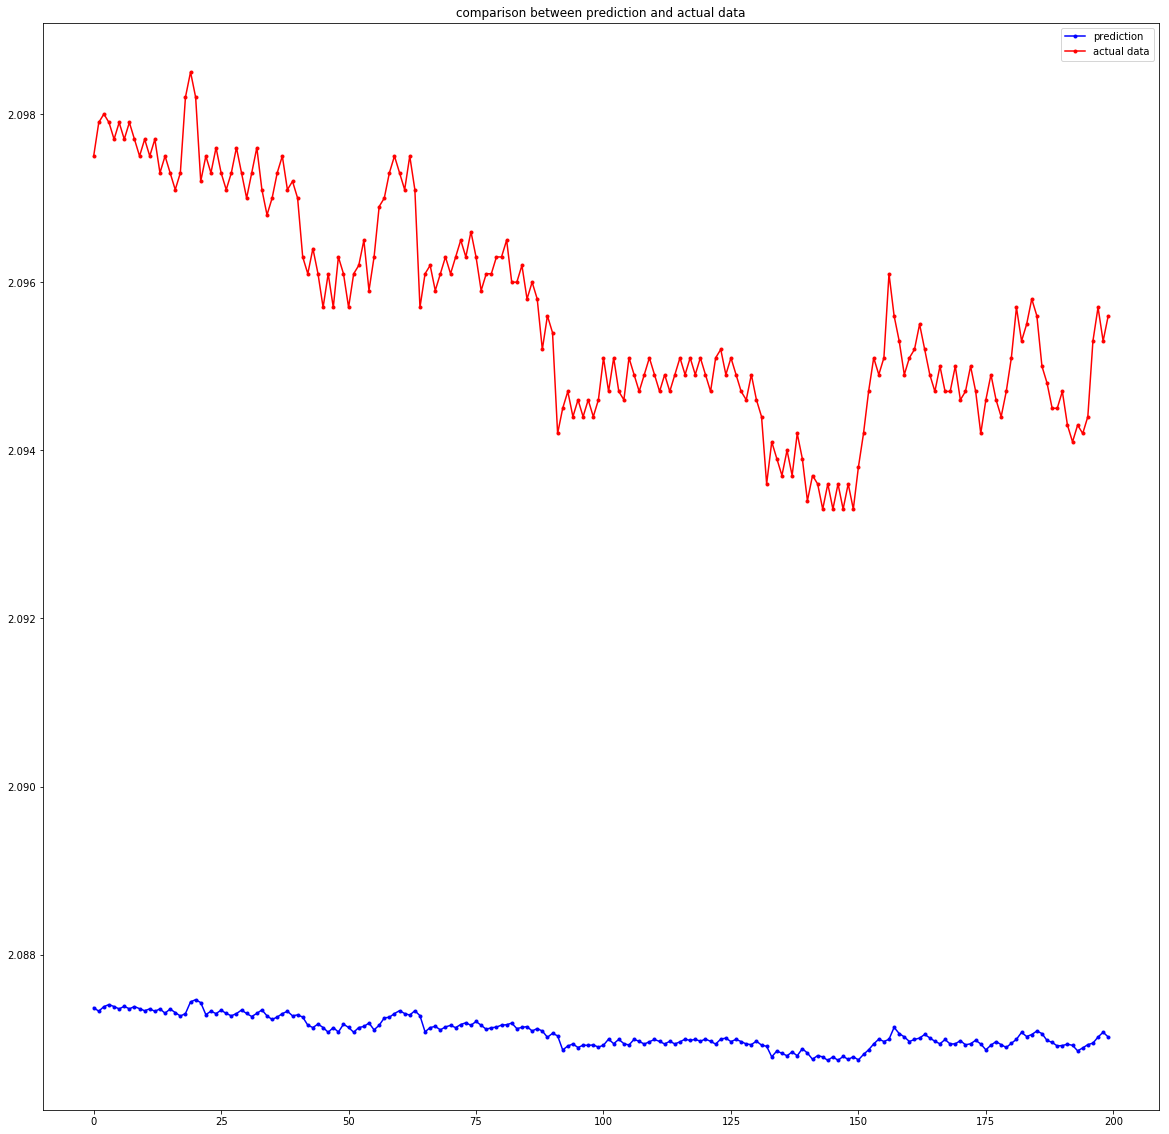

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 13342 samples, validate on 5717 samples
Epoch 1/50
 - 2s - loss: 0.0066 - val_loss: 0.0107
Epoch 2/50
 - 1s - loss: 0.0055 - val_loss: 0.0100
Epoch 3/50
 - 0s - loss: 0.0060 - val_loss: 0.0122
Epoch 4/50
 - 1s - loss: 0.0058 - val_loss: 0.0137
Epoch 5/50
 - 0s - loss: 0.0058 - val_loss: 0.0147
Epoch 6/50
 - 1s - loss: 0.0058 - val_loss: 0.0146
Epoch 7/50
 - 0s - loss: 0.0057 - val_loss: 0.0148
Epoch 8/50
 - 1s - loss: 0.0058 - val_loss: 0.0151
Epoch 9/50
 - 0s - loss: 0.0059 - val_loss: 0.0147
Epoch 10/50
 - 0s - loss: 0.0059 - val_loss: 0.0148
Epoch 11/50
 - 0s - loss: 0.0059 - val_loss: 0.0151
Epoch 12/50
 - 0s - loss: 0.0059 - val_loss: 0.0148
Epoch 13/50
 - 1s - loss: 0.0058 - val_loss: 0.0150
Epoch 14/50
 - 0s - loss: 0.0058 - val_loss: 0.0150
Epoch 15/50
 - 0s - loss: 0.0058 - val_loss: 0.0150
Epoch 16/50
 - 0s - loss: 0.0058 - val_loss: 0.0147
Epoch 17/50
 - 0s - loss: 0.0057 - val_loss: 0.0147
Epoch 18/50
 - 1s - loss: 0.0057 - val_loss: 0.0146
Epoch 19/50
 - 1s - loss

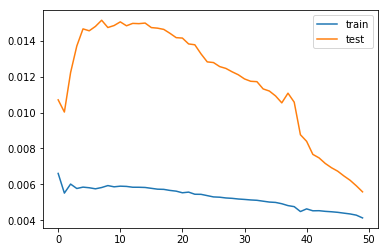

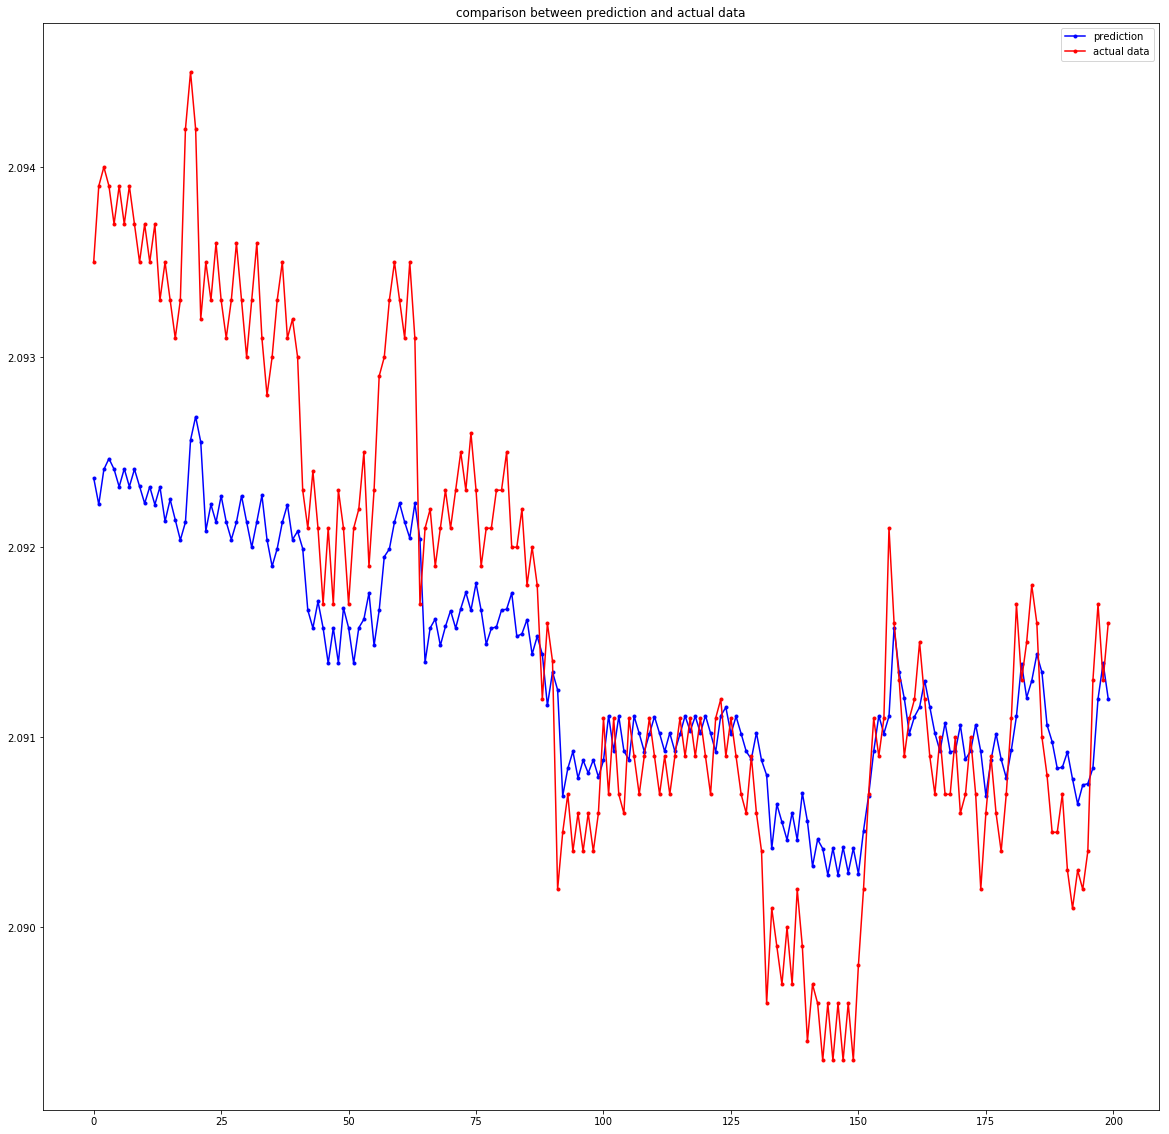

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 13342 samples, validate on 5717 samples
Epoch 1/50
 - 3s - loss: 0.0069 - val_loss: 0.0090
Epoch 2/50
 - 1s - loss: 0.0070 - val_loss: 0.0116
Epoch 3/50
 - 1s - loss: 0.0060 - val_loss: 0.0127
Epoch 4/50
 - 1s - loss: 0.0058 - val_loss: 0.0131
Epoch 5/50
 - 1s - loss: 0.0057 - val_loss: 0.0134
Epoch 6/50
 - 1s - loss: 0.0058 - val_loss: 0.0139
Epoch 7/50
 - 1s - loss: 0.0057 - val_loss: 0.0139
Epoch 8/50
 - 1s - loss: 0.0059 - val_loss: 0.0146
Epoch 9/50
 - 1s - loss: 0.0060 - val_loss: 0.0144
Epoch 10/50
 - 1s - loss: 0.0060 - val_loss: 0.0146
Epoch 11/50
 - 1s - loss: 0.0061 - val_loss: 0.0146
Epoch 12/50
 - 1s - loss: 0.0061 - val_loss: 0.0146
Epoch 13/50
 - 1s - loss: 0.0060 - val_loss: 0.0145
Epoch 14/50
 - 1s - loss: 0.0059 - val_loss: 0.0140
Epoch 15/50
 - 1s - loss: 0.0057 - val_loss: 0.0143
Epoch 16/50
 - 1s - loss: 0.0058 - val_loss: 0.0142
Epoch 17/50
 - 1s - loss: 0.0057 - val_loss: 0.0140
Epoch 18/50
 - 0s - loss: 0.0056 - val_loss: 0.0135
Epoch 19/50
 - 1s - loss

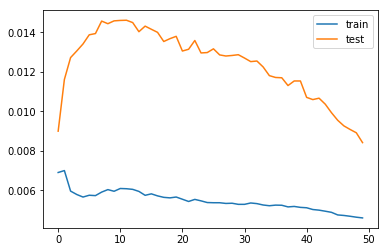

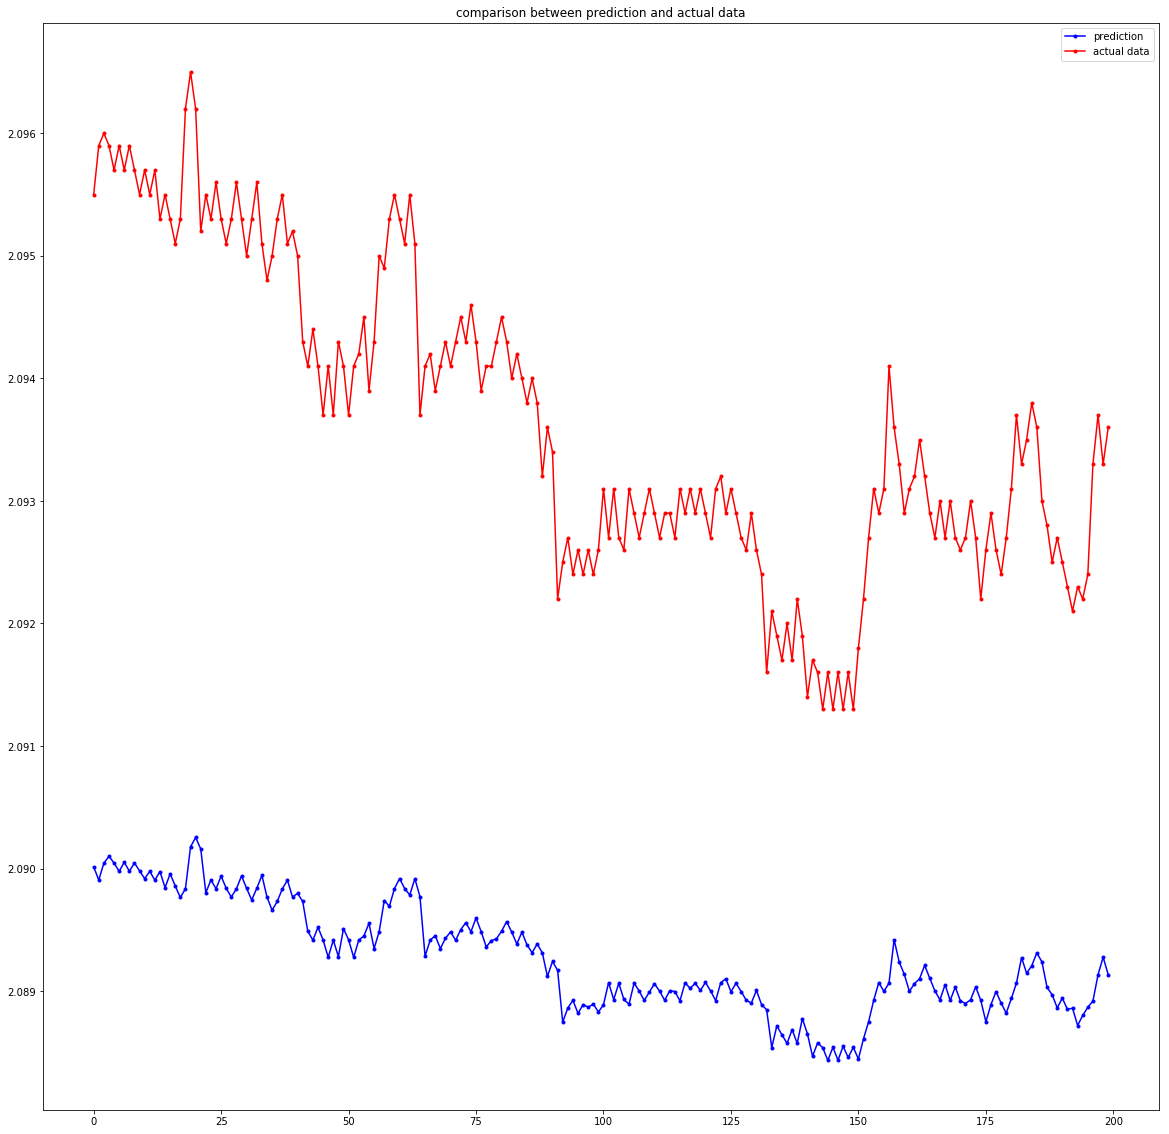

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 4642 samples, validate on 1988 samples
Epoch 1/50
 - 3s - loss: 0.1490 - val_loss: 0.3195
Epoch 2/50
 - 0s - loss: 0.0795 - val_loss: 0.2532
Epoch 3/50
 - 0s - loss: 0.0685 - val_loss: 0.2255
Epoch 4/50
 - 0s - loss: 0.0598 - val_loss: 0.1883
Epoch 5/50
 - 0s - loss: 0.0503 - val_loss: 0.1455
Epoch 6/50
 - 0s - loss: 0.0389 - val_loss: 0.0869
Epoch 7/50
 - 0s - loss: 0.0257 - val_loss: 0.0146
Epoch 8/50
 - 0s - loss: 0.0202 - val_loss: 0.0155
Epoch 9/50
 - 0s - loss: 0.0125 - val_loss: 0.0217
Epoch 10/50
 - 0s - loss: 0.0095 - val_loss: 0.0215
Epoch 11/50
 - 0s - loss: 0.0096 - val_loss: 0.0213
Epoch 12/50
 - 0s - loss: 0.0096 - val_loss: 0.0218
Epoch 13/50
 - 0s - loss: 0.0096 - val_loss: 0.0201
Epoch 14/50
 - 0s - loss: 0.0097 - val_loss: 0.0202
Epoch 15/50
 - 0s - loss: 0.0096 - val_loss: 0.0187
Epoch 16/50
 - 0s - loss: 0.0097 - val_loss: 0.0192
Epoch 17/50
 - 0s - loss: 0.0096 - val_loss: 0.0183
Epoch 18/50
 - 0s - loss: 0.0097 - val_loss: 0.0196
Epoch 19/50
 - 0s - loss:

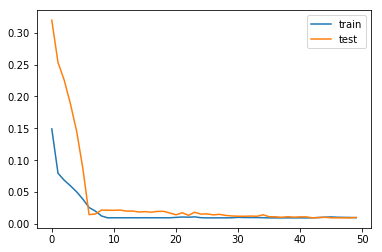

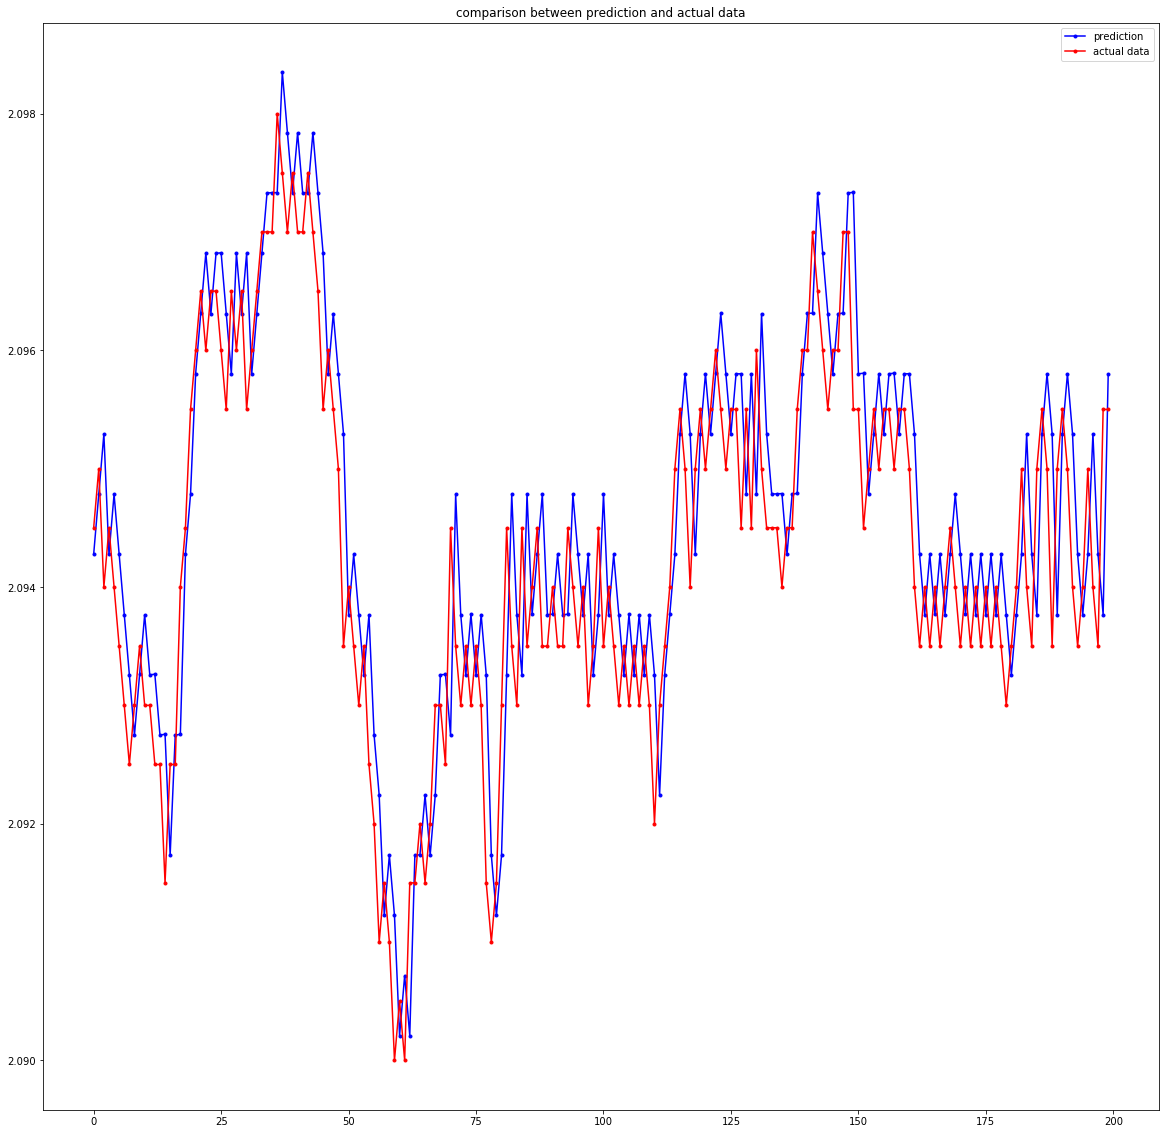

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 4642 samples, validate on 1988 samples
Epoch 1/50
 - 3s - loss: 0.1507 - val_loss: 0.3481
Epoch 2/50
 - 0s - loss: 0.0810 - val_loss: 0.2698
Epoch 3/50
 - 0s - loss: 0.0709 - val_loss: 0.2419
Epoch 4/50
 - 0s - loss: 0.0629 - val_loss: 0.2098
Epoch 5/50
 - 0s - loss: 0.0545 - val_loss: 0.1721
Epoch 6/50
 - 0s - loss: 0.0449 - val_loss: 0.1308
Epoch 7/50
 - 0s - loss: 0.0343 - val_loss: 0.0740
Epoch 8/50
 - 0s - loss: 0.0227 - val_loss: 0.0102
Epoch 9/50
 - 0s - loss: 0.0168 - val_loss: 0.0206
Epoch 10/50
 - 0s - loss: 0.0103 - val_loss: 0.0253
Epoch 11/50
 - 0s - loss: 0.0095 - val_loss: 0.0250
Epoch 12/50
 - 0s - loss: 0.0096 - val_loss: 0.0249
Epoch 13/50
 - 0s - loss: 0.0095 - val_loss: 0.0247
Epoch 14/50
 - 0s - loss: 0.0095 - val_loss: 0.0242
Epoch 15/50
 - 0s - loss: 0.0096 - val_loss: 0.0225
Epoch 16/50
 - 0s - loss: 0.0096 - val_loss: 0.0223
Epoch 17/50
 - 0s - loss: 0.0096 - val_loss: 0.0212
Epoch 18/50
 - 0s - loss: 0.0098 - val_loss: 0.0244
Epoch 19/50
 - 0s - loss:

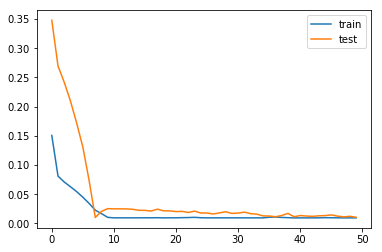

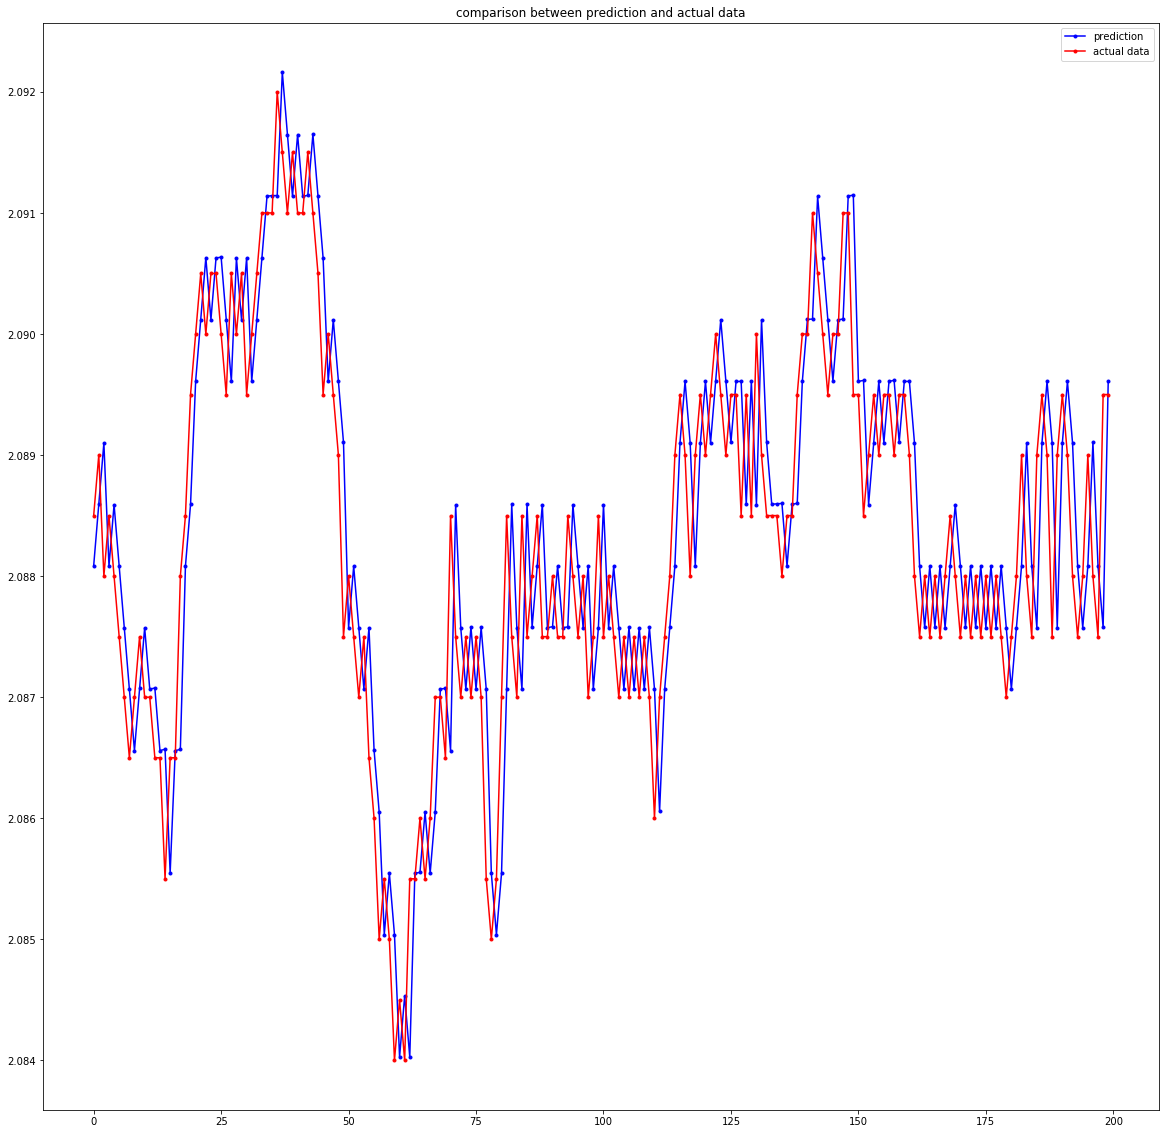

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 4642 samples, validate on 1988 samples
Epoch 1/50
 - 3s - loss: 0.1548 - val_loss: 0.3498
Epoch 2/50
 - 0s - loss: 0.0834 - val_loss: 0.2658
Epoch 3/50
 - 0s - loss: 0.0721 - val_loss: 0.2442
Epoch 4/50
 - 0s - loss: 0.0640 - val_loss: 0.2101
Epoch 5/50
 - 0s - loss: 0.0546 - val_loss: 0.1704
Epoch 6/50
 - 0s - loss: 0.0444 - val_loss: 0.1214
Epoch 7/50
 - 0s - loss: 0.0317 - val_loss: 0.0498
Epoch 8/50
 - 0s - loss: 0.0205 - val_loss: 0.0136
Epoch 9/50
 - 0s - loss: 0.0147 - val_loss: 0.0224
Epoch 10/50
 - 0s - loss: 0.0096 - val_loss: 0.0228
Epoch 11/50
 - 0s - loss: 0.0095 - val_loss: 0.0235
Epoch 12/50
 - 0s - loss: 0.0096 - val_loss: 0.0212
Epoch 13/50
 - 0s - loss: 0.0097 - val_loss: 0.0230
Epoch 14/50
 - 0s - loss: 0.0096 - val_loss: 0.0204
Epoch 15/50
 - 0s - loss: 0.0097 - val_loss: 0.0209
Epoch 16/50
 - 0s - loss: 0.0096 - val_loss: 0.0198
Epoch 17/50
 - 0s - loss: 0.0098 - val_loss: 0.0214
Epoch 18/50
 - 0s - loss: 0.0096 - val_loss: 0.0181
Epoch 19/50
 - 0s - loss:

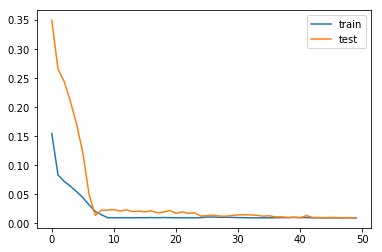

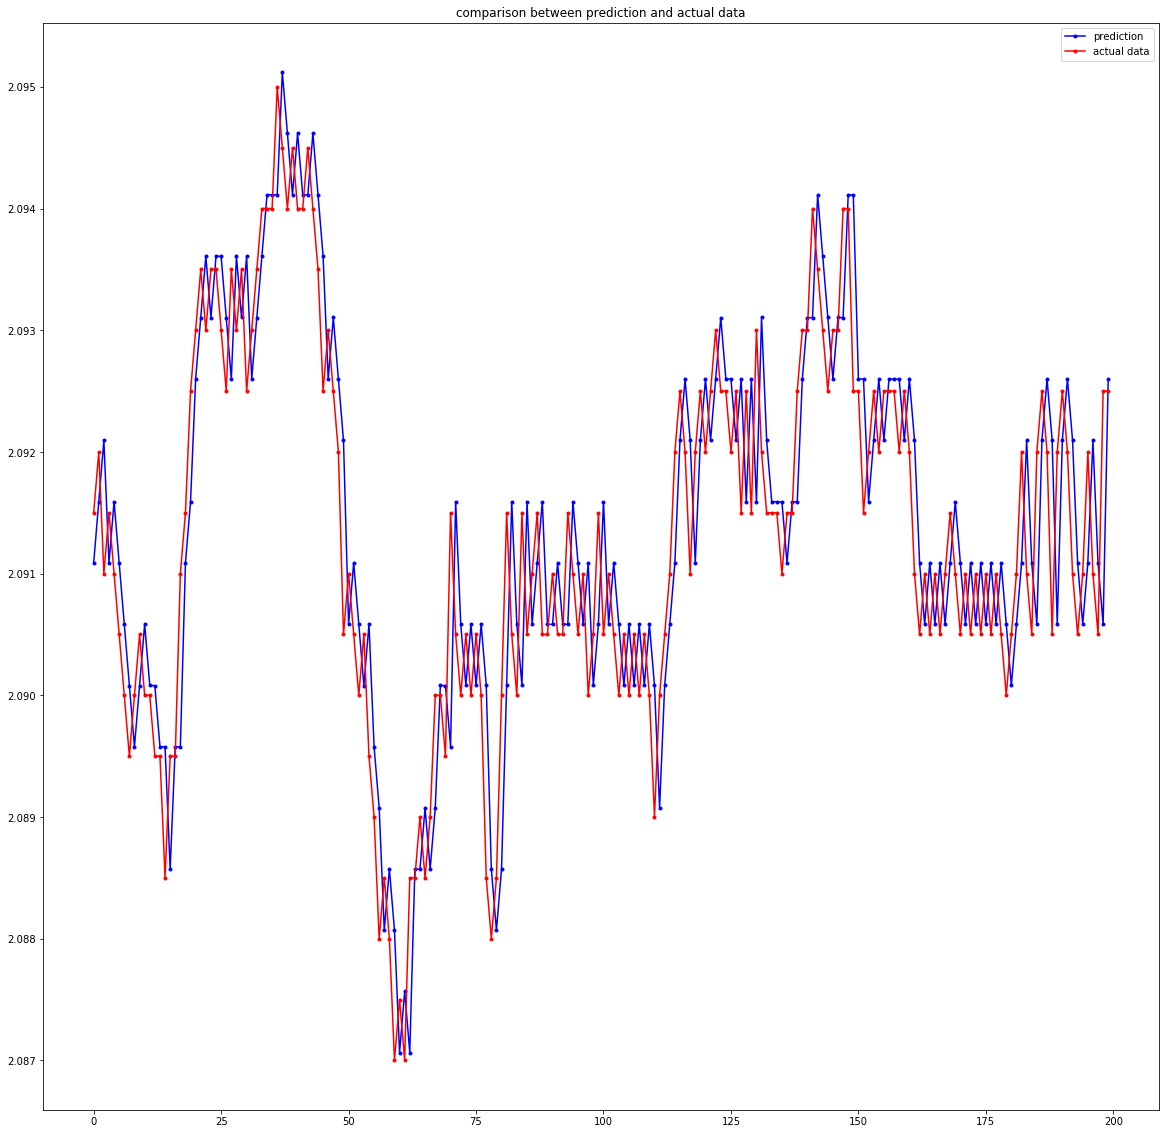

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 6874 samples, validate on 2945 samples
Epoch 1/50
 - 3s - loss: 0.1323 - val_loss: 0.2586
Epoch 2/50
 - 0s - loss: 0.0719 - val_loss: 0.2180
Epoch 3/50
 - 0s - loss: 0.0618 - val_loss: 0.1724
Epoch 4/50
 - 0s - loss: 0.0522 - val_loss: 0.1228
Epoch 5/50
 - 0s - loss: 0.0417 - val_loss: 0.0687
Epoch 6/50
 - 0s - loss: 0.0308 - val_loss: 0.0252
Epoch 7/50
 - 0s - loss: 0.0214 - val_loss: 0.0111
Epoch 8/50
 - 0s - loss: 0.0116 - val_loss: 0.0209
Epoch 9/50
 - 0s - loss: 0.0086 - val_loss: 0.0260
Epoch 10/50
 - 0s - loss: 0.0083 - val_loss: 0.0236
Epoch 11/50
 - 0s - loss: 0.0084 - val_loss: 0.0225
Epoch 12/50
 - 0s - loss: 0.0083 - val_loss: 0.0222
Epoch 13/50
 - 0s - loss: 0.0088 - val_loss: 0.0146
Epoch 14/50
 - 0s - loss: 0.0086 - val_loss: 0.0173
Epoch 15/50
 - 0s - loss: 0.0086 - val_loss: 0.0193
Epoch 16/50
 - 0s - loss: 0.0086 - val_loss: 0.0168
Epoch 17/50
 - 0s - loss: 0.0085 - val_loss: 0.0162
Epoch 18/50
 - 0s - loss: 0.0085 - val_loss: 0.0172
Epoch 19/50
 - 0s - loss:

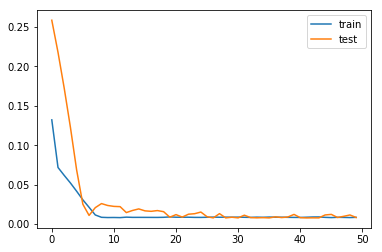

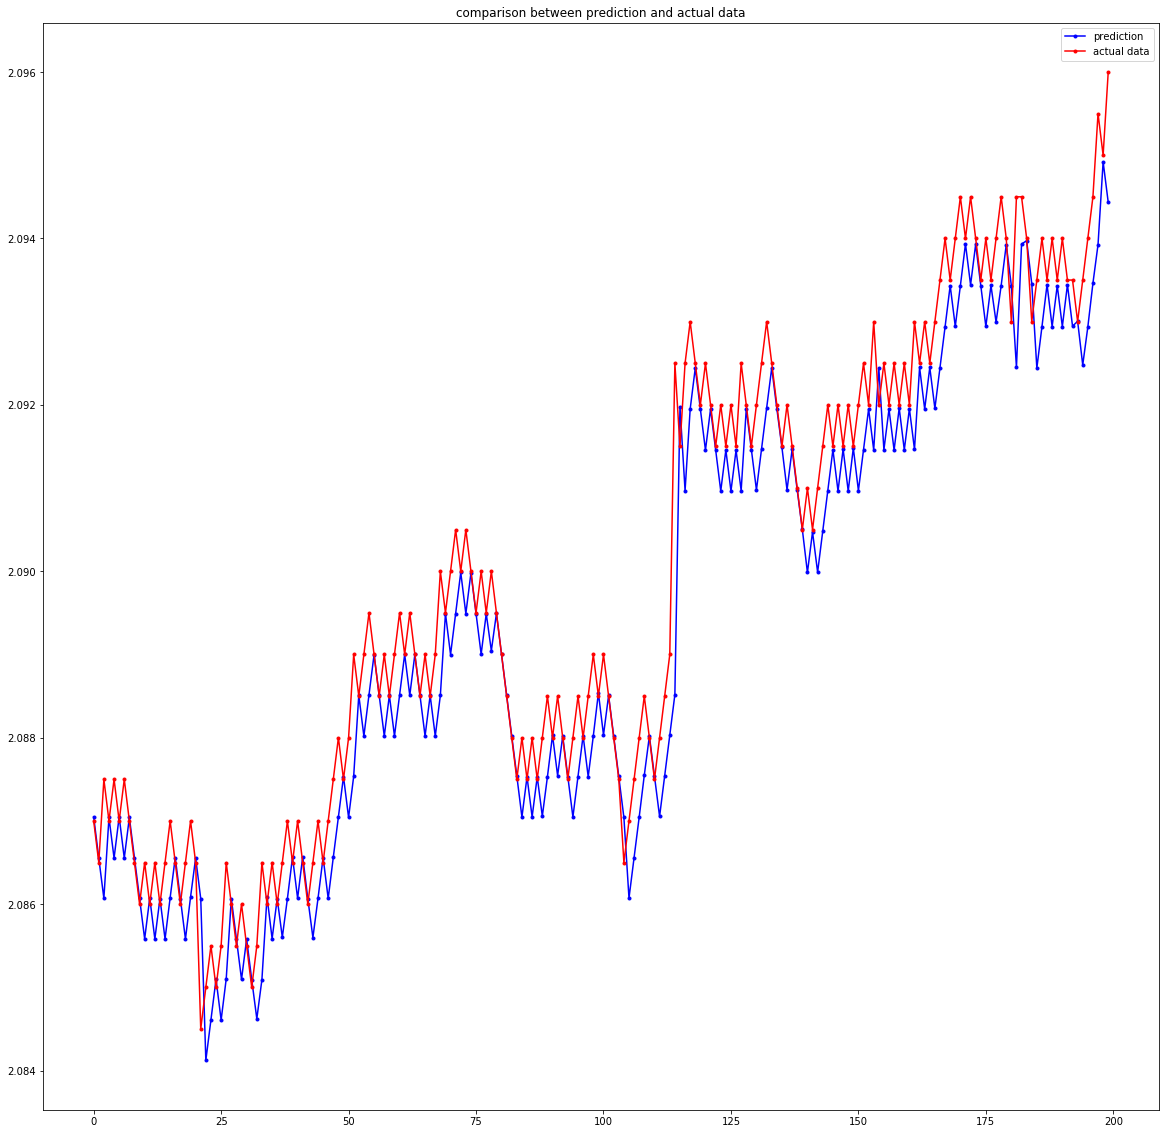

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 6856 samples, validate on 2937 samples
Epoch 1/50
 - 3s - loss: 0.1346 - val_loss: 0.2350
Epoch 2/50
 - 0s - loss: 0.0715 - val_loss: 0.1955
Epoch 3/50
 - 0s - loss: 0.0612 - val_loss: 0.1495
Epoch 4/50
 - 0s - loss: 0.0508 - val_loss: 0.0974
Epoch 5/50
 - 0s - loss: 0.0396 - val_loss: 0.0433
Epoch 6/50
 - 0s - loss: 0.0289 - val_loss: 0.0133
Epoch 7/50
 - 0s - loss: 0.0194 - val_loss: 0.0112
Epoch 8/50
 - 0s - loss: 0.0104 - val_loss: 0.0196
Epoch 9/50
 - 0s - loss: 0.0084 - val_loss: 0.0223
Epoch 10/50
 - 0s - loss: 0.0084 - val_loss: 0.0214
Epoch 11/50
 - 0s - loss: 0.0085 - val_loss: 0.0230
Epoch 12/50
 - 0s - loss: 0.0084 - val_loss: 0.0205
Epoch 13/50
 - 0s - loss: 0.0084 - val_loss: 0.0197
Epoch 14/50
 - 0s - loss: 0.0083 - val_loss: 0.0194
Epoch 15/50
 - 0s - loss: 0.0081 - val_loss: 0.0185
Epoch 16/50
 - 0s - loss: 0.0084 - val_loss: 0.0108
Epoch 17/50
 - 0s - loss: 0.0083 - val_loss: 0.0171
Epoch 18/50
 - 0s - loss: 0.0083 - val_loss: 0.0184
Epoch 19/50
 - 0s - loss:

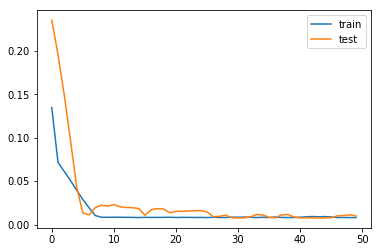

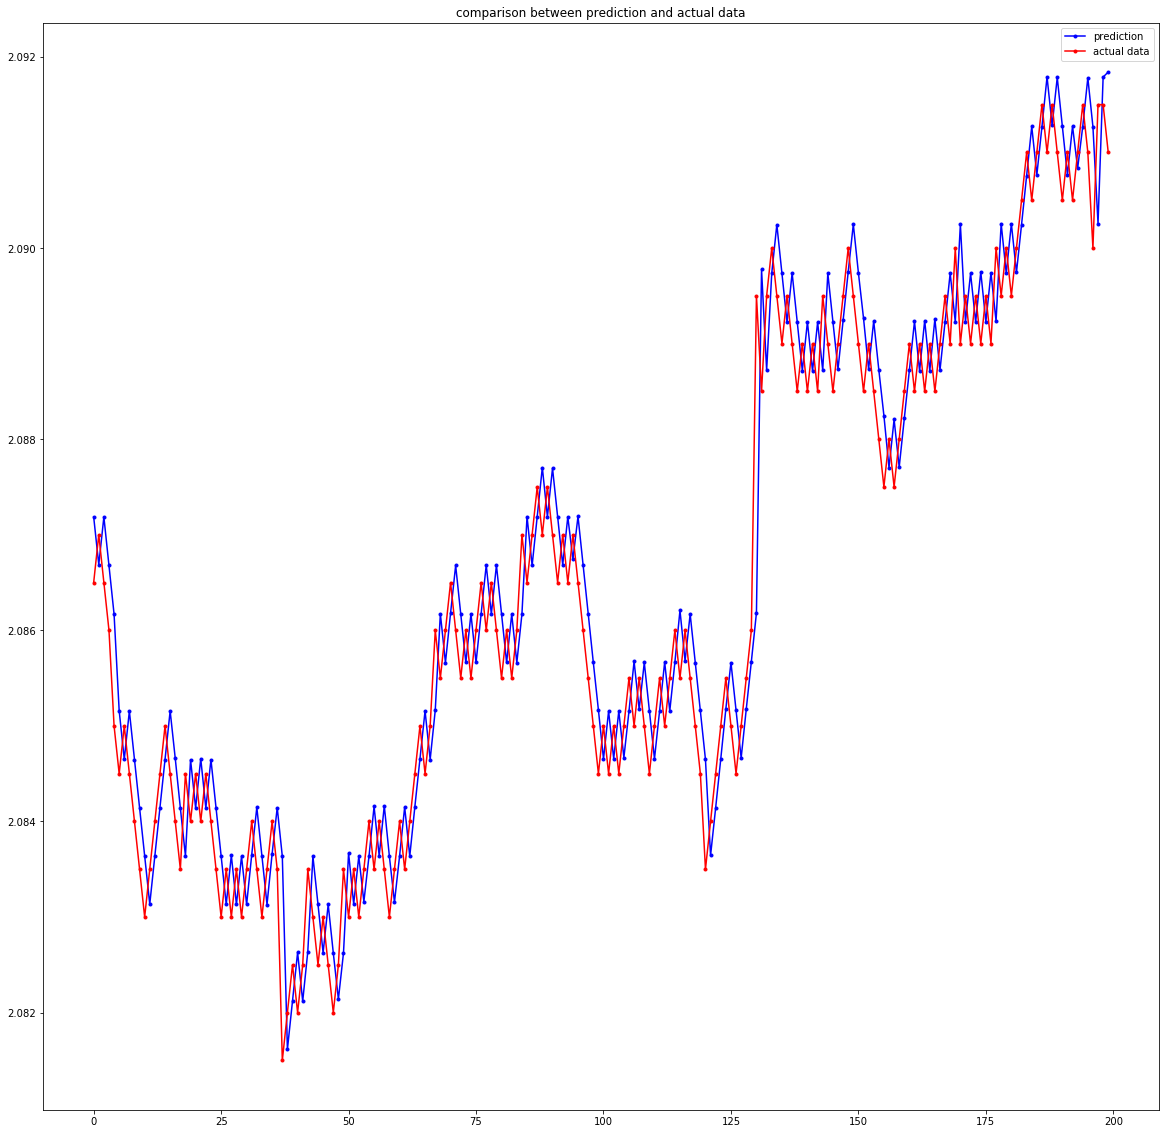

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 7623 samples, validate on 3266 samples
Epoch 1/50
 - 3s - loss: 0.1422 - val_loss: 0.2915
Epoch 2/50
 - 0s - loss: 0.0779 - val_loss: 0.2399
Epoch 3/50
 - 0s - loss: 0.0665 - val_loss: 0.1847
Epoch 4/50
 - 0s - loss: 0.0543 - val_loss: 0.1187
Epoch 5/50
 - 0s - loss: 0.0420 - val_loss: 0.0536
Epoch 6/50
 - 0s - loss: 0.0308 - val_loss: 0.0165
Epoch 7/50
 - 0s - loss: 0.0180 - val_loss: 0.0123
Epoch 8/50
 - 0s - loss: 0.0103 - val_loss: 0.0187
Epoch 9/50
 - 0s - loss: 0.0077 - val_loss: 0.0215
Epoch 10/50
 - 0s - loss: 0.0079 - val_loss: 0.0206
Epoch 11/50
 - 0s - loss: 0.0079 - val_loss: 0.0183
Epoch 12/50
 - 0s - loss: 0.0080 - val_loss: 0.0167
Epoch 13/50
 - 0s - loss: 0.0080 - val_loss: 0.0149
Epoch 14/50
 - 0s - loss: 0.0079 - val_loss: 0.0158
Epoch 15/50
 - 0s - loss: 0.0080 - val_loss: 0.0106
Epoch 16/50
 - 0s - loss: 0.0078 - val_loss: 0.0173
Epoch 17/50
 - 0s - loss: 0.0080 - val_loss: 0.0104
Epoch 18/50
 - 0s - loss: 0.0078 - val_loss: 0.0153
Epoch 19/50
 - 0s - loss:

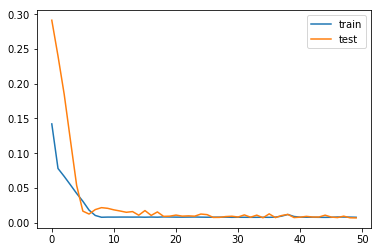

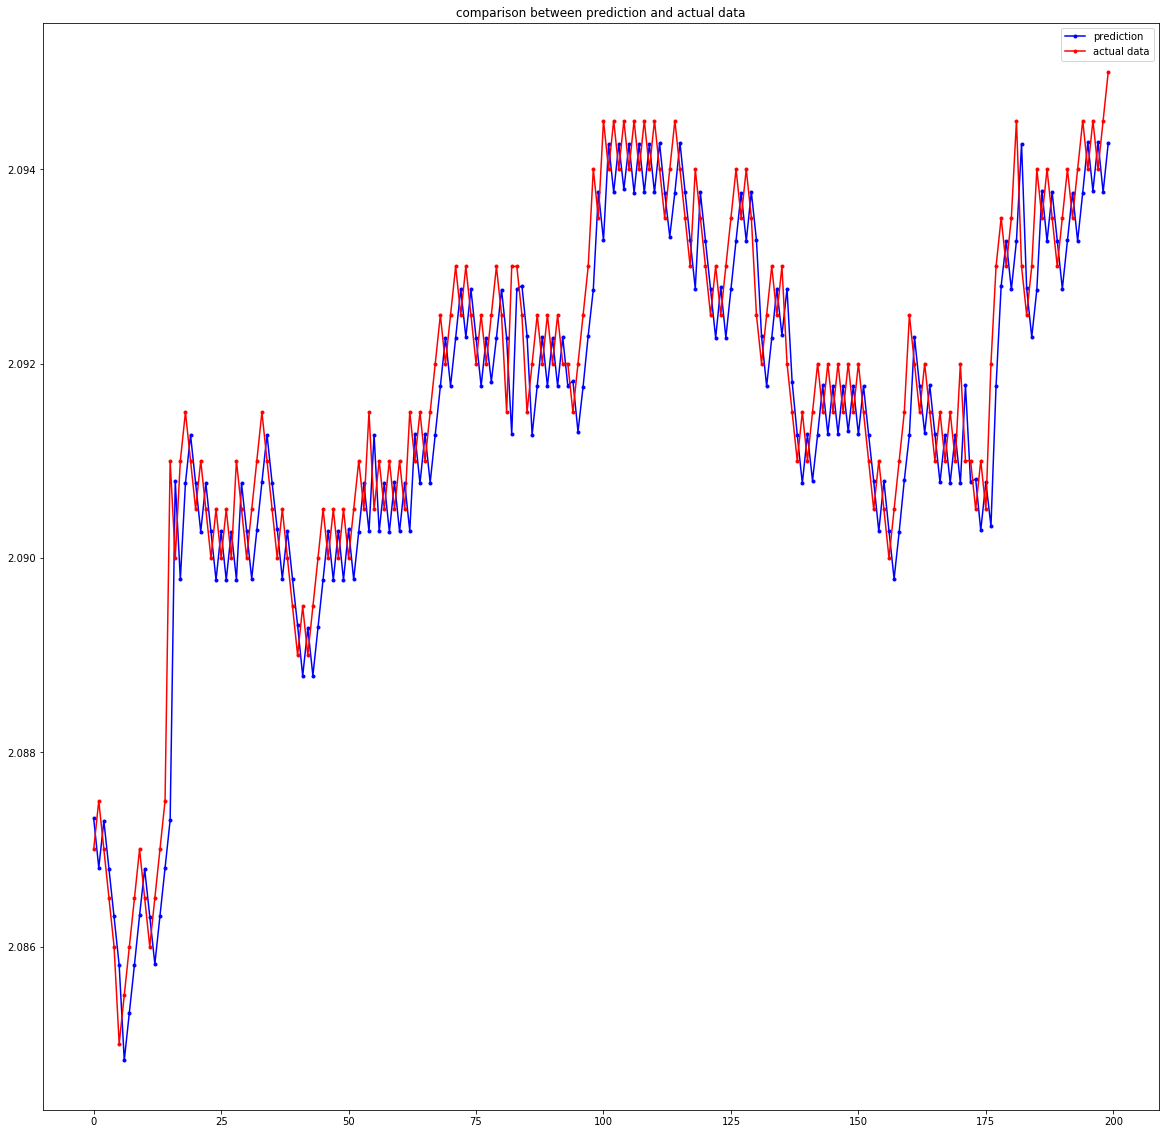

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 15133 samples, validate on 6484 samples
Epoch 1/50
 - 4s - loss: 0.0720 - val_loss: 0.1177
Epoch 2/50
 - 1s - loss: 0.0459 - val_loss: 0.0877
Epoch 3/50
 - 1s - loss: 0.0348 - val_loss: 0.0715
Epoch 4/50
 - 1s - loss: 0.0233 - val_loss: 0.0200
Epoch 5/50
 - 1s - loss: 0.0096 - val_loss: 0.0099
Epoch 6/50
 - 1s - loss: 0.0069 - val_loss: 0.0047
Epoch 7/50
 - 1s - loss: 0.0054 - val_loss: 0.0041
Epoch 8/50
 - 1s - loss: 0.0054 - val_loss: 0.0041
Epoch 9/50
 - 1s - loss: 0.0056 - val_loss: 0.0042
Epoch 10/50
 - 1s - loss: 0.0054 - val_loss: 0.0040
Epoch 11/50
 - 1s - loss: 0.0055 - val_loss: 0.0040
Epoch 12/50
 - 1s - loss: 0.0055 - val_loss: 0.0041
Epoch 13/50
 - 1s - loss: 0.0054 - val_loss: 0.0039
Epoch 14/50
 - 1s - loss: 0.0055 - val_loss: 0.0041
Epoch 15/50
 - 1s - loss: 0.0054 - val_loss: 0.0039
Epoch 16/50
 - 1s - loss: 0.0055 - val_loss: 0.0039
Epoch 17/50
 - 1s - loss: 0.0054 - val_loss: 0.0039
Epoch 18/50
 - 1s - loss: 0.0054 - val_loss: 0.0040
Epoch 19/50
 - 1s - loss

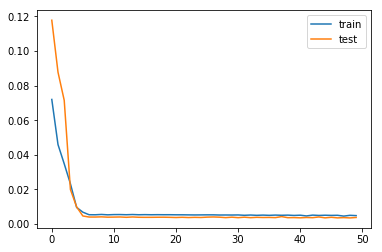

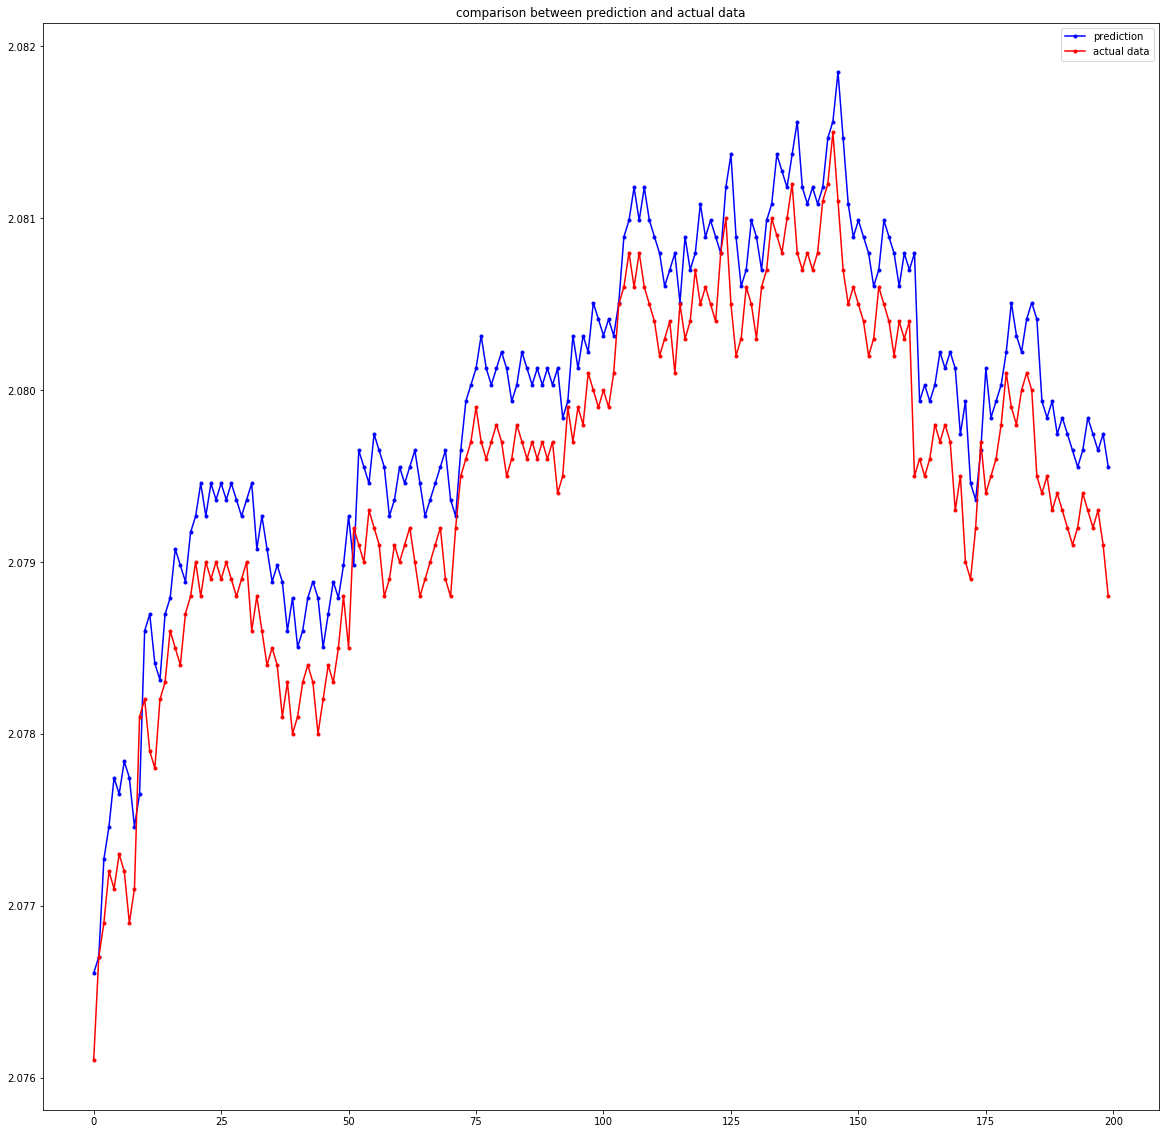

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 15936 samples, validate on 6829 samples
Epoch 1/50
 - 4s - loss: 0.1428 - val_loss: 0.1268
Epoch 2/50
 - 1s - loss: 0.0533 - val_loss: 0.1100
Epoch 3/50
 - 1s - loss: 0.0473 - val_loss: 0.0924
Epoch 4/50
 - 1s - loss: 0.0405 - val_loss: 0.0971
Epoch 5/50
 - 1s - loss: 0.0368 - val_loss: 0.0823
Epoch 6/50
 - 1s - loss: 0.0317 - val_loss: 0.0665
Epoch 7/50
 - 1s - loss: 0.0265 - val_loss: 0.0495
Epoch 8/50
 - 1s - loss: 0.0187 - val_loss: 0.0238
Epoch 9/50
 - 1s - loss: 0.0126 - val_loss: 0.0191
Epoch 10/50
 - 1s - loss: 0.0107 - val_loss: 0.0113
Epoch 11/50
 - 1s - loss: 0.0091 - val_loss: 0.0058
Epoch 12/50
 - 1s - loss: 0.0079 - val_loss: 0.0048
Epoch 13/50
 - 1s - loss: 0.0075 - val_loss: 0.0042
Epoch 14/50
 - 1s - loss: 0.0054 - val_loss: 0.0041
Epoch 15/50
 - 1s - loss: 0.0048 - val_loss: 0.0068
Epoch 16/50
 - 1s - loss: 0.0042 - val_loss: 0.0084
Epoch 17/50
 - 1s - loss: 0.0039 - val_loss: 0.0092
Epoch 18/50
 - 1s - loss: 0.0036 - val_loss: 0.0111
Epoch 19/50
 - 1s - loss

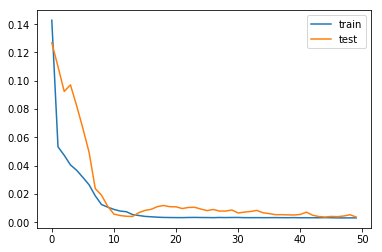

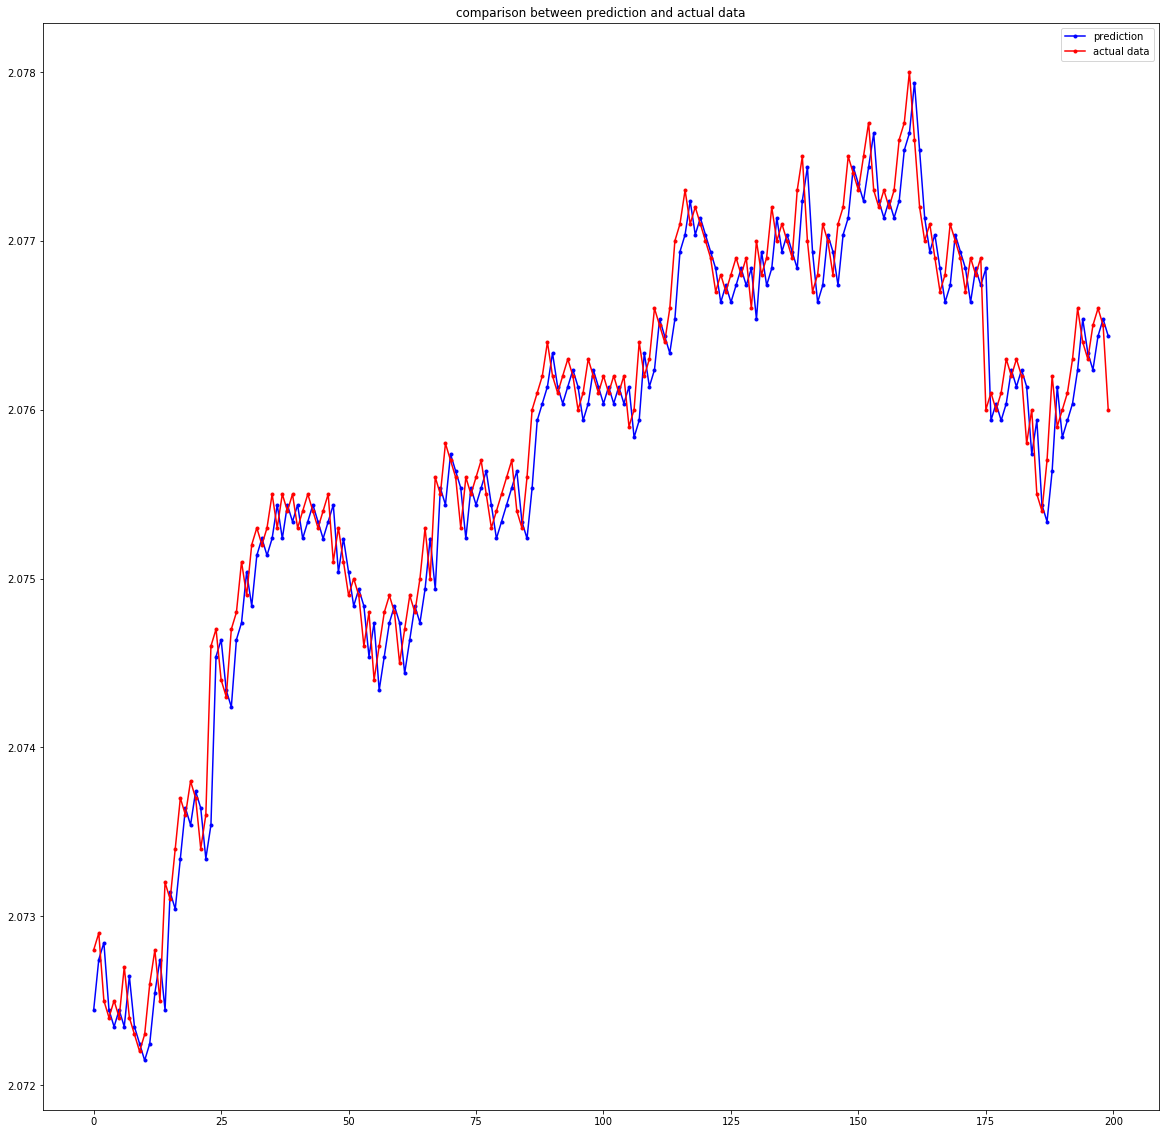

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 17581 samples, validate on 7533 samples
Epoch 1/50
 - 4s - loss: 0.0965 - val_loss: 0.1562
Epoch 2/50
 - 1s - loss: 0.0552 - val_loss: 0.1116
Epoch 3/50
 - 1s - loss: 0.0370 - val_loss: 0.0607
Epoch 4/50
 - 1s - loss: 0.0247 - val_loss: 0.0228
Epoch 5/50
 - 1s - loss: 0.0109 - val_loss: 0.0084
Epoch 6/50
 - 1s - loss: 0.0081 - val_loss: 0.0045
Epoch 7/50
 - 1s - loss: 0.0073 - val_loss: 0.0056
Epoch 8/50
 - 1s - loss: 0.0078 - val_loss: 0.0049
Epoch 9/50
 - 1s - loss: 0.0062 - val_loss: 0.0062
Epoch 10/50
 - 1s - loss: 0.0058 - val_loss: 0.0059
Epoch 11/50
 - 1s - loss: 0.0050 - val_loss: 0.0070
Epoch 12/50
 - 1s - loss: 0.0044 - val_loss: 0.0138
Epoch 13/50
 - 1s - loss: 0.0042 - val_loss: 0.0134
Epoch 14/50
 - 1s - loss: 0.0039 - val_loss: 0.0144
Epoch 15/50
 - 1s - loss: 0.0039 - val_loss: 0.0148
Epoch 16/50
 - 1s - loss: 0.0039 - val_loss: 0.0147
Epoch 17/50
 - 1s - loss: 0.0038 - val_loss: 0.0138
Epoch 18/50
 - 1s - loss: 0.0038 - val_loss: 0.0125
Epoch 19/50
 - 1s - loss

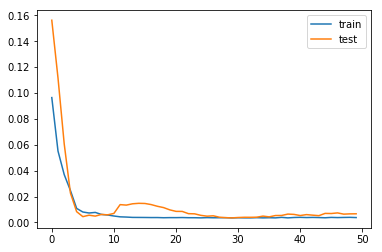

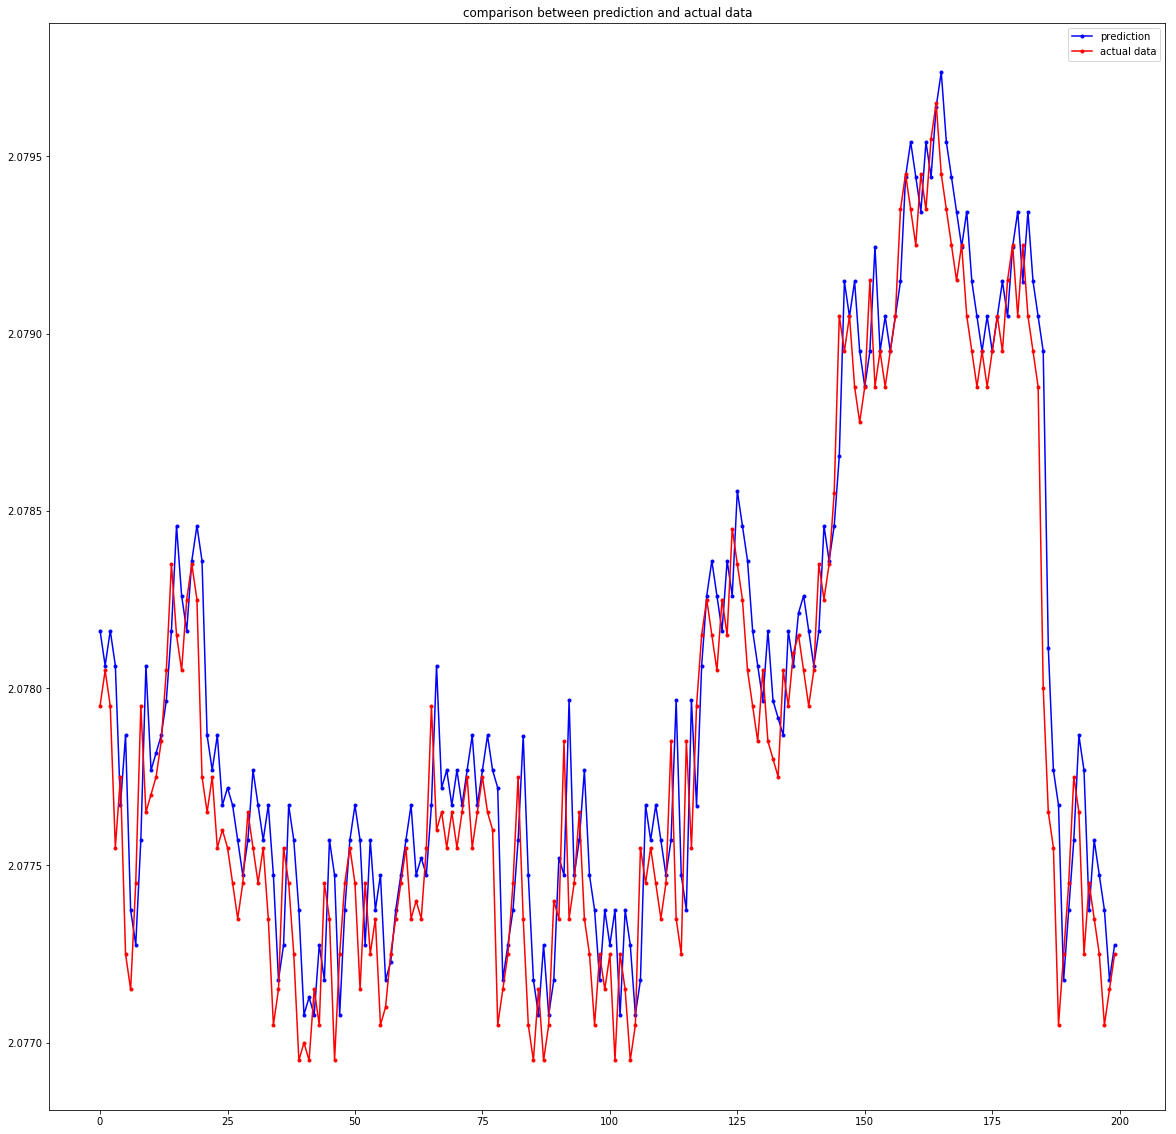

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 2662 samples, validate on 1139 samples
Epoch 1/50
 - 4s - loss: 0.3096 - val_loss: 0.4453
Epoch 2/50
 - 0s - loss: 0.1626 - val_loss: 0.2285
Epoch 3/50
 - 0s - loss: 0.1035 - val_loss: 0.1656
Epoch 4/50
 - 0s - loss: 0.0972 - val_loss: 0.1573
Epoch 5/50
 - 0s - loss: 0.0893 - val_loss: 0.1437
Epoch 6/50
 - 0s - loss: 0.0819 - val_loss: 0.1290
Epoch 7/50
 - 0s - loss: 0.0740 - val_loss: 0.1143
Epoch 8/50
 - 0s - loss: 0.0659 - val_loss: 0.0967
Epoch 9/50
 - 0s - loss: 0.0578 - val_loss: 0.0816
Epoch 10/50
 - 0s - loss: 0.0491 - val_loss: 0.0636
Epoch 11/50
 - 0s - loss: 0.0411 - val_loss: 0.0498
Epoch 12/50
 - 0s - loss: 0.0311 - val_loss: 0.0253
Epoch 13/50
 - 0s - loss: 0.0240 - val_loss: 0.0198
Epoch 14/50
 - 0s - loss: 0.0205 - val_loss: 0.0203
Epoch 15/50
 - 0s - loss: 0.0197 - val_loss: 0.0202
Epoch 16/50
 - 0s - loss: 0.0195 - val_loss: 0.0206
Epoch 17/50
 - 0s - loss: 0.0195 - val_loss: 0.0207
Epoch 18/50
 - 0s - loss: 0.0195 - val_loss: 0.0212
Epoch 19/50
 - 0s - loss:

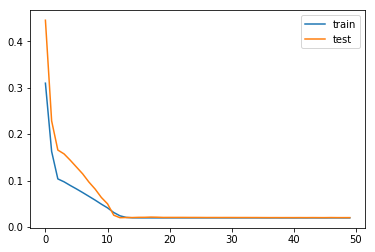

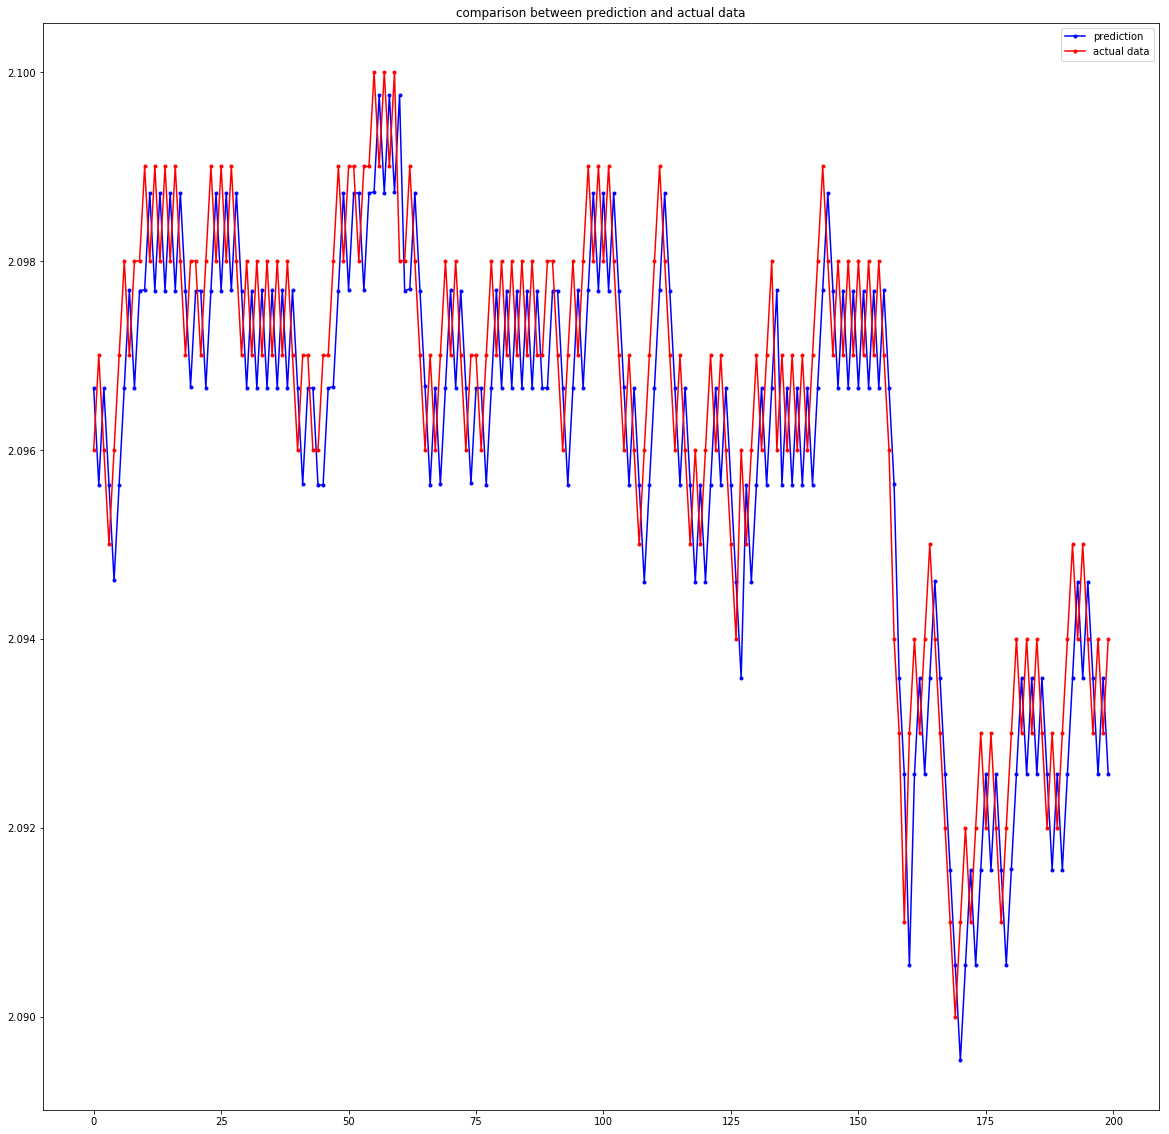

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 2653 samples, validate on 1135 samples
Epoch 1/50
 - 4s - loss: 0.3332 - val_loss: 0.4861
Epoch 2/50
 - 0s - loss: 0.1875 - val_loss: 0.2805
Epoch 3/50
 - 0s - loss: 0.1107 - val_loss: 0.1655
Epoch 4/50
 - 0s - loss: 0.1039 - val_loss: 0.1690
Epoch 5/50
 - 0s - loss: 0.0942 - val_loss: 0.1508
Epoch 6/50
 - 0s - loss: 0.0870 - val_loss: 0.1370
Epoch 7/50
 - 0s - loss: 0.0799 - val_loss: 0.1225
Epoch 8/50
 - 0s - loss: 0.0723 - val_loss: 0.1081
Epoch 9/50
 - 0s - loss: 0.0643 - val_loss: 0.0918
Epoch 10/50
 - 0s - loss: 0.0566 - val_loss: 0.0777
Epoch 11/50
 - 0s - loss: 0.0485 - val_loss: 0.0629
Epoch 12/50
 - 0s - loss: 0.0397 - val_loss: 0.0439
Epoch 13/50
 - 0s - loss: 0.0302 - val_loss: 0.0220
Epoch 14/50
 - 0s - loss: 0.0238 - val_loss: 0.0200
Epoch 15/50
 - 0s - loss: 0.0208 - val_loss: 0.0213
Epoch 16/50
 - 0s - loss: 0.0198 - val_loss: 0.0211
Epoch 17/50
 - 0s - loss: 0.0196 - val_loss: 0.0211
Epoch 18/50
 - 0s - loss: 0.0196 - val_loss: 0.0213
Epoch 19/50
 - 0s - loss:

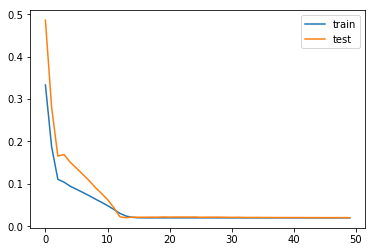

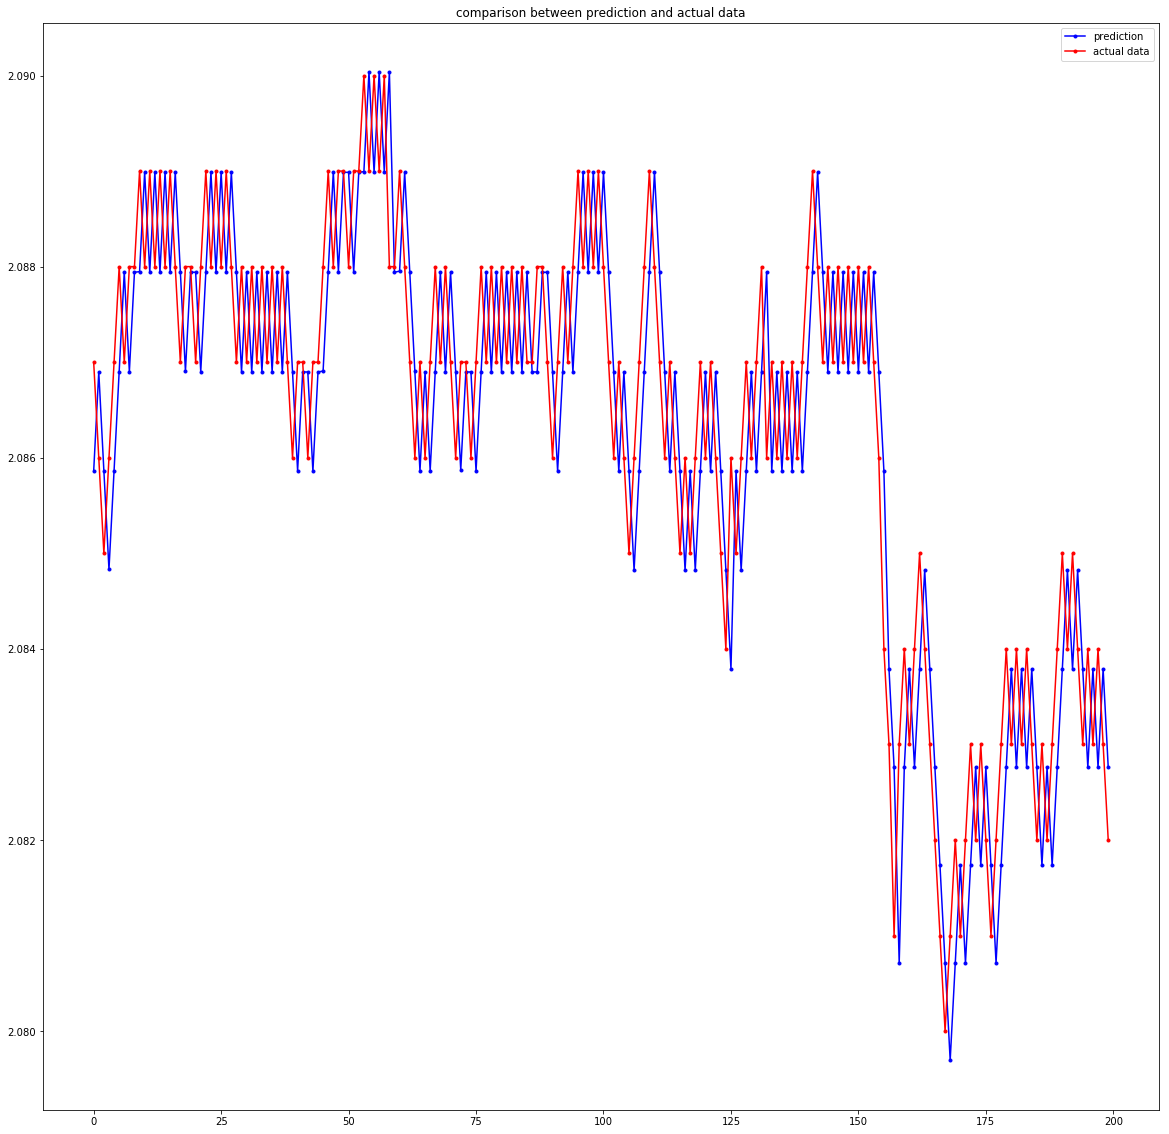

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 2698 samples, validate on 1155 samples
Epoch 1/50
 - 4s - loss: 0.3429 - val_loss: 0.5046
Epoch 2/50
 - 0s - loss: 0.1983 - val_loss: 0.2989
Epoch 3/50
 - 0s - loss: 0.1154 - val_loss: 0.1698
Epoch 4/50
 - 0s - loss: 0.1075 - val_loss: 0.1726
Epoch 5/50
 - 0s - loss: 0.0977 - val_loss: 0.1549
Epoch 6/50
 - 0s - loss: 0.0908 - val_loss: 0.1418
Epoch 7/50
 - 0s - loss: 0.0825 - val_loss: 0.1246
Epoch 8/50
 - 0s - loss: 0.0748 - val_loss: 0.1100
Epoch 9/50
 - 0s - loss: 0.0660 - val_loss: 0.0927
Epoch 10/50
 - 0s - loss: 0.0570 - val_loss: 0.0758
Epoch 11/50
 - 0s - loss: 0.0476 - val_loss: 0.0564
Epoch 12/50
 - 0s - loss: 0.0369 - val_loss: 0.0322
Epoch 13/50
 - 0s - loss: 0.0272 - val_loss: 0.0195
Epoch 14/50
 - 0s - loss: 0.0209 - val_loss: 0.0199
Epoch 15/50
 - 0s - loss: 0.0199 - val_loss: 0.0204
Epoch 16/50
 - 0s - loss: 0.0194 - val_loss: 0.0211
Epoch 17/50
 - 0s - loss: 0.0193 - val_loss: 0.0210
Epoch 18/50
 - 0s - loss: 0.0193 - val_loss: 0.0217
Epoch 19/50
 - 0s - loss:

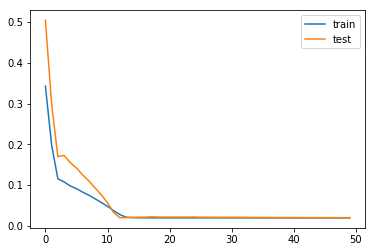

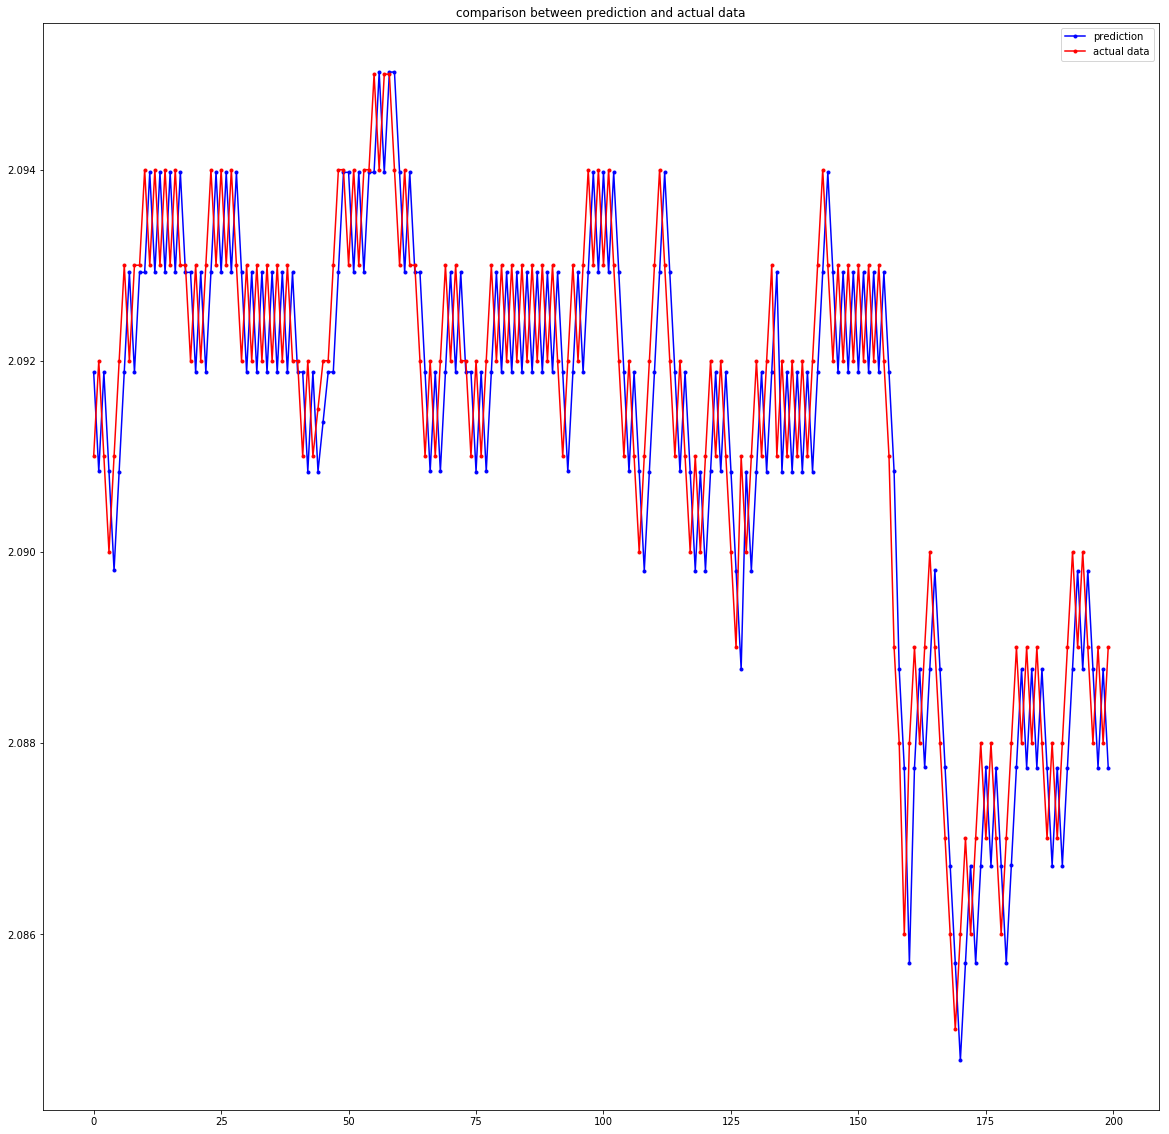

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train on 13884 samples, validate on 5949 samples
Epoch 1/50
 - 16s - loss: 0.1332 - val_loss: 0.1927
Epoch 2/50
 - 12s - loss: 0.0658 - val_loss: 0.1429
Epoch 3/50
 - 10s - loss: 0.0526 - val_loss: 0.0921
Epoch 4/50
 - 10s - loss: 0.0400 - val_loss: 0.0570
Epoch 5/50
 - 10s - loss: 0.0265 - val_loss: 0.0264
Epoch 6/50
 - 11s - loss: 0.0153 - val_loss: 0.0231
Epoch 7/50
 - 10s - loss: 0.0106 - val_loss: 0.0130
Epoch 8/50
 - 10s - loss: 0.0105 - val_loss: 0.0115
Epoch 9/50
 - 10s - loss: 0.0102 - val_loss: 0.0116
Epoch 10/50
 - 10s - loss: 0.0101 - val_loss: 0.0116
Epoch 11/50
 - 9s - loss: 0.0102 - val_loss: 0.0118
Epoch 12/50
 - 12s - loss: 0.0100 - val_loss: 0.0117
Epoch 13/50
 - 11s - loss: 0.0101 - val_loss: 0.0118
Epoch 14/50


In [ ]:
with open('/tmp/USSWAP15-sorted.dat', 'r') as file: 
    data = [] 
    next(file) 
    for i in range(1000000): 
        line = file.readline() 
        info = line.rstrip().split(',')
        if float(info[-1]) != 0:
            data.append(info) 
        columnLabels = "tickerid|0|srcid|ts|date|flags|flags|type|price"
    #create DataFrame
    df = pd.DataFrame(data = np.array(data), columns = columnLabels.split('|'))

    dates = df['date']
    split_dates = []

    for elem in dates:
        split_dates.append(elem.replace('_',' '))
    df['date'] = split_dates
    df['date'] = df.date.astype('datetime64[ns]')
    df['price'] = df.price.astype('float')
    df = df.drop(columns = ['0', 'ts', 'flags'])
    df = df.set_index('date')
    
    
    

    df = df.reset_index()
    df = df.set_index('srcid')
    #display(df)

    #src_97c = df.loc[:rindex('97c'), :]
    #display(src_97c)
    contributors = df.groupby('srcid')
    #df = df.reset_index()
    #df = df.set_index('srcid')
    #price_type = df.groupby('type')
    for x in contributors.groups:
        by_contrib = contributors.get_group(x)
        types = by_contrib.groupby('type')
        for y in types.groups:
            lastTime = -9999
            time_elapsed = []
            by_types = types.get_group(y)
            #add column for time differences
                    #by_types['timeElapsed'] 
            for i in range(len(by_types)):
                currentTime = by_types.iloc[i]['date']
                #print(by_types.dtypes)
                if lastTime == -9999:
                    time_elapsed.append(0)
                else:
                    time_elapsed.append((currentTime-lastTime).total_seconds())
                lastTime = currentTime
            by_types['timeElapsed'] = time_elapsed
            by_types = by_types.reset_index()
            by_types = by_types.set_index('date')
            #display(by_types)

            #reframed = reformat_data(by_types)

            #train_X, train_y, test_X, test_y = train_test_split(reframed)

            by_types = by_types.drop(columns = ['tickerid', 'srcid', 'type'])
            #values = (by_types.values)
            #values = by_types.values
            #print(values)
            #values = values.reshape(len(values), 1, 2)
            #print(values)
            #train_X, test_X, train_y, test_y = train_test(values, by_types)
            #print(train_X.shape)
            #print(test_X.shape)
            #print(train_y.shape)
            #print(test_y.shape)
            
            train_model(by_types)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print ("%f - mean absolute error")%(mean_absolute_error(final_pred,actual_pred) )
print ("%f - mean squared error")%(mean_squared_error(final_pred,actual_pred))